In [1]:
import math
from xlrd import open_workbook
import xlsxwriter
from collections import Counter
import numpy as np
from datetime import datetime
from datetime import date
import xlrd
import math
import operator
import time
from operator import itemgetter
import pandas as pd

import string
from nltk import word_tokenize    
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from xlrd import open_workbook
from numpy.lib.stride_tricks import as_strided
import re
import nltk
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('sentiwordnet')
from nltk import pos_tag
from nltk.corpus import stopwords
import nltk.tokenize.punkt
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

# Product-centric

# Prodcut-centric-Behavior-feature

In [342]:
#read data
Product_Behavior = pd.read_excel("C:\\Users\\Harmony Chen\\Documents\\JupyterLab\\Code-and-Results-master\\Data\\YelpNYC\\Metadata (Sortedby_Product_wise).xlsx")# Change the path according to the file location

In [343]:
Counter(Product_Behavior["Label"])

Counter({-1: 6898, 1: 84008})

In [344]:
Product_Behavior["Date"].nunique()

2893

In [345]:
Product_Behavior.head()

,Reviewer_id,Product_id,Rating,Label,Date,Count (P)
0,923,0,3,-1,2014-12-08,98
1,927,0,4,-1,2010-11-01,98
2,930,0,4,-1,2007-05-20,98
3,931,0,4,-1,2005-12-27,98
4,940,0,4,1,2014-09-16,98


In [346]:
Product_Behavior.nunique()

Reviewer_id    15351
Product_id       873
Rating             5
Label              2
Date            2893
Count (P)        278
dtype: int64

In [347]:
#major summary in each product_id
Product_Behavior_group_rank_average = Product_Behavior.groupby(["Product_id"])["Rating"].mean()
Product_Behavior_group_rank_sd = Product_Behavior.groupby(["Product_id"])["Rating"].std()
Product_Behavior_group_date_min = Product_Behavior.groupby(["Product_id"])["Date"].min()
Product_Behavior_group_date_max = Product_Behavior.groupby(["Product_id"])["Date"].max()

In [348]:
#most common rating
Product_Behavior_group_rank_common = Product_Behavior.groupby(["Product_id"])["Rating"].agg(lambda x:x.value_counts().index[0])

In [349]:
#EXRR,TRRR,BRRR,RPR,RNR
Product_Behavior_group_extreme_rating_ratio = Product_Behavior.groupby(["Product_id"])["Rating"].apply(lambda x : sum(x==5|1)/sum(x))
Product_Behavior_group_toprating_rating_ratio = Product_Behavior.groupby(["Product_id"])["Rating"].apply(lambda x : sum(x==5)/sum(x))
Product_Behavior_group_buttomrating_rating_ratio = Product_Behavior.groupby(["Product_id"])["Rating"].apply(lambda x : sum(x==1)/sum(x))
Product_Behavior_group_posrating_rating_ratio = Product_Behavior.groupby(["Product_id"])["Rating"].apply(lambda x : sum(x==4|5)/sum(x))
Product_Behavior_group_negrating_rating_ratio = Product_Behavior.groupby(["Product_id"])["Rating"].apply(lambda x : sum(x==1|2)/sum(x))

In [356]:
Product_Behavior_grouped = pd.concat([Product_Behavior_group_rank_average,Product_Behavior_group_rank_sd,
                                      Product_Behavior_group_rank_common,Product_Behavior_group_date_min,
                                      Product_Behavior_group_date_max,Product_Behavior_group_extreme_rating_ratio,
                                      Product_Behavior_group_toprating_rating_ratio,Product_Behavior_group_buttomrating_rating_ratio,
                                      Product_Behavior_group_posrating_rating_ratio,Product_Behavior_group_negrating_rating_ratio],axis=1)

In [357]:
Product_Behavior_grouped.columns = [["Product_Average_Rank","Product_Rank_SD",
                                     "Product_Behavior_group_rank_common","Product_early_date",
                                     "Product_final_date","Product_Behavior_group_extreme_rating_ratio",
                                     "Product_Behavior_group_toprating_rating_ratio","Product_Behavior_group_buttomrating_rating_ratio",
                                    "Product_Behavior_group_posrating_rating_ratio","Product_Behavior_group_negrating_rating_ratio"]]

In [358]:
Product_Behavior_grouped.head()

,Product_Average_Rank,Product_Rank_SD,Product_Behavior_group_rank_common,Product_early_date,Product_final_date,Product_Behavior_group_extreme_rating_ratio,Product_Behavior_group_toprating_rating_ratio,Product_Behavior_group_buttomrating_rating_ratio,Product_Behavior_group_posrating_rating_ratio,Product_Behavior_group_negrating_rating_ratio
Product_id,,,,,,,,,,
0,3.959184,0.772175,4,2005-04-21,2014-12-08,0.054124,0.054124,0.000000,0.054124,0.033505
1,4.047619,0.887704,4,2008-07-16,2014-09-09,0.082353,0.082353,0.003922,0.082353,0.043137
2,3.792453,1.115597,4,2013-09-14,2014-12-28,0.079602,0.079602,0.009950,0.079602,0.044776
3,4.187500,0.981071,5,2014-01-27,2014-12-20,0.119403,0.119403,0.000000,0.119403,0.044776
4,3.917241,0.721721,4,2010-07-30,2014-12-06,0.042254,0.042254,0.001761,0.042254,0.040493


In [359]:
Product_Behavior=Product_Behavior.merge(Product_Behavior_grouped,how = "left",on="Product_id")

In [360]:
Product_Behavior=Product_Behavior.merge(pd.DataFrame(Product_Behavior_Early_Review_Ratio,columns=["Product_Behavior_Early_Review_Ratio"]),how = "left",on="Product_id")

In [361]:
Product_Behavior.head()

,Reviewer_id,Product_id,Rating,Label,Date,Count (P),"(Product_Average_Rank,)","(Product_Rank_SD,)","(Product_Behavior_group_rank_common,)","(Product_early_date,)","(Product_final_date,)","(Product_Behavior_group_extreme_rating_ratio,)","(Product_Behavior_group_toprating_rating_ratio,)","(Product_Behavior_group_buttomrating_rating_ratio,)","(Product_Behavior_group_posrating_rating_ratio,)","(Product_Behavior_group_negrating_rating_ratio,)",Product_Behavior_Early_Review_Ratio
0,923,0,3,-1,2014-12-08,98,3.959184,0.772175,4,2005-04-21,2014-12-08,0.054124,0.054124,0.0,0.054124,0.033505,0.010204
1,927,0,4,-1,2010-11-01,98,3.959184,0.772175,4,2005-04-21,2014-12-08,0.054124,0.054124,0.0,0.054124,0.033505,0.010204
2,930,0,4,-1,2007-05-20,98,3.959184,0.772175,4,2005-04-21,2014-12-08,0.054124,0.054124,0.0,0.054124,0.033505,0.010204
3,931,0,4,-1,2005-12-27,98,3.959184,0.772175,4,2005-04-21,2014-12-08,0.054124,0.054124,0.0,0.054124,0.033505,0.010204
4,940,0,4,1,2014-09-16,98,3.959184,0.772175,4,2005-04-21,2014-12-08,0.054124,0.054124,0.0,0.054124,0.033505,0.010204


In [382]:
#rename columns
columns = Product_Behavior.columns.tolist()
columns = [column[0] if len(column[0])>1 else column for column in columns ]

Product_Behavior.columns=[columns]

In [385]:
Product_Behavior.head()

,Reviewer_id,Product_id,Rating,Label,Date,Count (P),Product_Average_Rank,Product_Rank_SD,Product_Behavior_group_rank_common,Product_early_date,Product_final_date,Product_Behavior_group_extreme_rating_ratio,Product_Behavior_group_toprating_rating_ratio,Product_Behavior_group_buttomrating_rating_ratio,Product_Behavior_group_posrating_rating_ratio,Product_Behavior_group_negrating_rating_ratio,Product_Behavior_Early_Review_Ratio
0,923,0,3,-1,2014-12-08,98,3.959184,0.772175,4,2005-04-21,2014-12-08,0.054124,0.054124,0.0,0.054124,0.033505,0.010204
1,927,0,4,-1,2010-11-01,98,3.959184,0.772175,4,2005-04-21,2014-12-08,0.054124,0.054124,0.0,0.054124,0.033505,0.010204
2,930,0,4,-1,2007-05-20,98,3.959184,0.772175,4,2005-04-21,2014-12-08,0.054124,0.054124,0.0,0.054124,0.033505,0.010204
3,931,0,4,-1,2005-12-27,98,3.959184,0.772175,4,2005-04-21,2014-12-08,0.054124,0.054124,0.0,0.054124,0.033505,0.010204
4,940,0,4,1,2014-09-16,98,3.959184,0.772175,4,2005-04-21,2014-12-08,0.054124,0.054124,0.0,0.054124,0.033505,0.010204


In [443]:
Product_Behavior.to_excel("Product-centric-Behavior-feature.xlsx")

# Product-centric-Textual-feature

In [405]:
import nltk

In [416]:
Product_ReviewContent = pd.read_excel("C:\\Users\\Harmony Chen\\Documents\\JupyterLab\\Code-and-Results-master\\Data\\YelpNYC\\ReviewContent (Sortedby_Product_wise).xlsx")

Product_ReviewContent["Text"] = Product_ReviewContent["Text"].astype(str)

def prepare_text_for_nltk(text):
    # convert all words into lower case, split by white space
    text = row['Text'].replace('...', '').replace('!', '').replace(",",'').replace(".",'')

    tokens = text.strip().split()
    
    # remove English stopwords (as defined by NLTK)
    return tokens

text_data = []
for index,row in Product_ReviewContent.iterrows():
    text_data.append(prepare_text_for_nltk(row["Text"]))

PRP_data = []
for text in text_data:
    PRP_data.append([word for (word,tag) in nltk.pos_tag(text) if "PRP" in tag])

Product_ReviewContent["Tag_PRP"] = pd.Series(PRP_data)


KeyboardInterrupt: 

In [ ]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
review_corpus = []
for index,row in Product_ReviewContent.iterrows():
    text = row['Text'].replace('...', '').replace('!', '').replace(",",'').replace(".",'')
    review_corpus.append(text)

In [ ]:
SUB_data = []
OBJ_data = []
for text in review_corpus:
    text = nlp(text)
    SUB_data.append([token.text for token in text if token.dep_=="nsubj"])
    OBJ_data.append([token.text for token in text if token.dep_ in ["dobj","pobj"]]) 

In [ ]:
for index,row in Product_ReviewContent.iterrows():
    if len(row["Tag_PRP"])==0:
        row["Tag_PRP"]=0


In [ ]:
len(Product_ReviewContent["Tag_PRP"][2])

In [ ]:
Product_ReviewContent["SUB_Data"] = pd.Series(SUB_data)
Product_ReviewContent["OBJ_Data"] = pd.Series(OBJ_data)

In [ ]:
Product_ReviewContent[] = len(Product_ReviewContent["Text"])

In [ ]:
Sent_len = []
Sub_len = []
Obj_len = []

for text in review_corpus:
    Sent_len.append(len(text))

for index,row in Product_ReviewContent.iterrows():
    Sub_len.append(len(row["SUB_Data"])) 
    Obj_len.append(len(row["OBJ_Data"]))
Product_ReviewContent["SUB_Len"] = pd.Series(Sub_len)
Product_ReviewContent["OBJ_Len"] = pd.Series(Obj_len)

In [ ]:
Product_ReviewContent["Sent_len"]=pd.Series(Sent_len)

In [ ]:
Product_ReviewContent.head()

In [ ]:
First_Third_PRP = []
Second_PRP = []
First_Third_PRP_ratio = []
Second_PRP_ratio = []
first_third_pronoun = ["i",'we','our','ourselves','us','my','mine','myself',
                       'me','he','his','him','himself','she','her','hers','herself',
                       'they','them','themselves','theirs','their',]

second_pronoun = ['you','your','yourself','yours']
for index,row in Product_ReviewContent.iterrows():
    first_third_list =[word for word in row["Tag_PRP"] if word.lower() in first_third_pronoun]
    second_list =[word for word in row["Tag_PRP"] if word.lower() in second_pronoun]
    First_Third_PRP.append(len(first_third_list))
    Second_PRP.append(len(second_list))

    if row["Sent_len"]==0:
        First_Third_PRP_ratio.append(0) 
        Second_PRP_ratio.append(0)
    else:  
        First_Third_PRP_ratio.append(len(first_third_list)/row["Sent_len"]) 
        Second_PRP_ratio.append(len(second_list)/row["Sent_len"])
        
Product_ReviewContent["First_Third_PRP"] =pd.Series(First_Third_PRP)       
Product_ReviewContent["First_Third_PRP_ratio"] = pd.Series(First_Third_PRP_ratio)
Product_ReviewContent["Second_PRP"]=pd.Series(Second_PRP)
Product_ReviewContent["Second_PRP_ratio"] = pd.Series(Second_PRP_ratio)

In [409]:
#ARL,AFPP,ASPP,AFTAPP,ASAPP,ASW,AOW

Product_ReviewContent_group_avg_sent_len= Product_ReviewContent.groupby("Product_id")["Sent_len"].mean()
Product_ReviewContent_group_avg_first_third_ratio = Product_ReviewContent.groupby("Product_id")["First_Third_PRP","Sent_len"].apply(lambda x: sum(x["First_Third_PRP"])/sum(x["Sent_len"]))
Product_ReviewContent_group_avg_second_ratio = Product_ReviewContent.groupby("Product_id")["Second_PRP","Sent_len"].apply(lambda x: sum(x["Second_PRP"])/sum(x["Sent_len"]))
Product_ReviewContent_group_avg_sub_ratio = Product_ReviewContent.groupby("Product_id")["SUB_Len","Sent_len"].apply(lambda x: sum(x["SUB_Len"])/sum(x["Sent_len"]))
Product_ReviewContent_group_avg_obj_ratio = Product_ReviewContent.groupby("Product_id")["OBJ_Len","Sent_len"].apply(lambda x: sum(x["OBJ_Len"])/sum(x["Sent_len"]))

Product_ReviewContent_group_avg_sub_to_allpro_ratio = Product_ReviewContent.groupby("Product_id")["SUB_Len","OBJ_Len"].apply(lambda x: sum(x["SUB_Len"])/(sum(x["OBJ_Len"])+sum(x["SUB_Len"])) )
Product_ReviewContent_group_avg_obj_to_allpro_ratio = Product_ReviewContent.groupby("Product_id")["SUB_Len","OBJ_Len"].apply(lambda x: sum(x["OBJ_Len"])/(sum(x["OBJ_Len"])+sum(x["SUB_Len"])) )

                                                                                                                                    

KeyError: 'Column not found: Sent_len'

In [219]:
Product_ReviewContent_grouped= pd.concat([Product_ReviewContent_group_avg_sent_len,
                                        Product_ReviewContent_group_avg_first_third_ratio,Product_ReviewContent_group_avg_second_ratio,
                                        Product_ReviewContent_group_avg_sub_ratio,Product_ReviewContent_group_avg_obj_ratio,
                                        Product_ReviewContent_group_avg_sub_to_allpro_ratio, Product_ReviewContent_group_avg_obj_to_allpro_ratio],
                                        axis=1)

In [221]:
Product_ReviewContent_grouped.columns = [["Product_ReviewContent_avg_sent_len",
                                         "Product_ReviewContent_avg_first_third_ratio",'Product_ReviewContent_avg_second_ratio',
                                         'Product_ReviewContent_avg_sub_ratio','Product_ReviewContent_avg_obj_ratio',
                                         'Product_ReviewContent_avg_sub_to_allpro_ratio','Product_ReviewContent_avg_obj_to_allpro_ratio']]

In [223]:
Product_ReviewContent =Product_ReviewContent.merge(Product_ReviewContent_grouped,how = "left",on="Product_id")

In [225]:
Product_ReviewContent.to_excel("Product-centric-Text-feature.xlsx")

In [612]:
Product_ReviewContent=pd.read_excel("Product-centric-Text-feature.xlsx")

In [613]:
columns = Product_ReviewContent.columns.tolist()

In [614]:
columns

['Reviewer_id',
 'Product_id',
 'Date',
 'Text',
 'Count (P)',
 'Tag_PRP',
 'SUB_Data',
 'OBJ_Data',
 'Sent_len',
 'SUB_Len',
 'OBJ_Len',
 'First_Third_PRP',
 'First_Third_PRP_ratio',
 'Second_PRP',
 'Second_PRP_ratio',
 'Product_ReviewContent_avg_sent_len',
 'Product_ReviewContent_avg_first_third_ratio',
 'Product_ReviewContent_avg_second_ratio',
 'Product_ReviewContent_avg_sub_ratio',
 'Product_ReviewContent_avg_obj_ratio',
 'Product_ReviewContent_avg_sub_to_allpro_ratio',
 'Product_ReviewContent_avg_obj_to_allpro_ratio']

In [615]:
columns[5:15]=["Product_ReviewContent_"+column for column in columns[5:15]]
columns

['Reviewer_id',
 'Product_id',
 'Date',
 'Text',
 'Count (P)',
 'Product_ReviewContent_Tag_PRP',
 'Product_ReviewContent_SUB_Data',
 'Product_ReviewContent_OBJ_Data',
 'Product_ReviewContent_Sent_len',
 'Product_ReviewContent_SUB_Len',
 'Product_ReviewContent_OBJ_Len',
 'Product_ReviewContent_First_Third_PRP',
 'Product_ReviewContent_First_Third_PRP_ratio',
 'Product_ReviewContent_Second_PRP',
 'Product_ReviewContent_Second_PRP_ratio',
 'Product_ReviewContent_avg_sent_len',
 'Product_ReviewContent_avg_first_third_ratio',
 'Product_ReviewContent_avg_second_ratio',
 'Product_ReviewContent_avg_sub_ratio',
 'Product_ReviewContent_avg_obj_ratio',
 'Product_ReviewContent_avg_sub_to_allpro_ratio',
 'Product_ReviewContent_avg_obj_to_allpro_ratio']

In [427]:
columns = Product_ReviewContent.columns.tolist()
columns =[column[2:-3] if column[0]=="(" else column for column in columns]

In [616]:
Product_ReviewContent.columns = [columns]

In [617]:
Product_ReviewContent.head()

,Reviewer_id,Product_id,Date,Text,Count (P),Product_ReviewContent_Tag_PRP,Product_ReviewContent_SUB_Data,Product_ReviewContent_OBJ_Data,Product_ReviewContent_Sent_len,Product_ReviewContent_SUB_Len,...,Product_ReviewContent_First_Third_PRP_ratio,Product_ReviewContent_Second_PRP,Product_ReviewContent_Second_PRP_ratio,Product_ReviewContent_avg_sent_len,Product_ReviewContent_avg_first_third_ratio,Product_ReviewContent_avg_second_ratio,Product_ReviewContent_avg_sub_ratio,Product_ReviewContent_avg_obj_ratio,Product_ReviewContent_avg_sub_to_allpro_ratio,Product_ReviewContent_avg_obj_to_allpro_ratio
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,98,['We'],"['food', 'tray', 'it']","['snack', 'dishes', 'courses']",211,3,...,0.004739,0,0.000000,508.622449,0.009249,0.001444,0.019541,0.022931,0.460085,0.539915
1,927,0,2010-11-01,Snack is great place for a Â casual sit down l...,98,"['it', 'I', 'you', 'their', 'you']","['Snack', 'restaurant', 'soup', 'bean', 'coffe...","['casual', 'day', 'ways', 'simple', 'hearty', ...",588,11,...,0.003401,2,0.003401,508.622449,0.009249,0.001444,0.019541,0.022931,0.460085,0.539915
2,930,0,2007-05-20,Love this place! Â Try the Chicken sandwich or...,98,[],"['\xa0', 'Those', '\xa0']","['place', 'sandwich']",134,3,...,0.000000,0,0.000000,508.622449,0.009249,0.001444,0.019541,0.022931,0.460085,0.539915
3,931,0,2005-12-27,My friend and I were intrigued by the nightly ...,98,"['My', 'I', 'we', 'we', 'we', 'I', 'I', 'they'...","['we', 'we', 'we', 'I', 'I', 'they', 'we', 'ci...","['Shoes', 'sirloin', 'Snack', 'glass', 'wine',...",564,10,...,0.019504,0,0.000000,508.622449,0.009249,0.001444,0.019541,0.022931,0.460085,0.539915
4,940,0,2014-09-16,"For lunch, my friend and I had: -Lamb sandwich...",98,"['my', 'I', 'my', 'it', 'I', 'I', 'it', 'they'...","['I', 'friend', 'I', 'I', 'Avolemono', 'friend...","['lunch', 'friend', 'beet', 'portion', 'thing'...",438,9,...,0.013699,1,0.002283,508.622449,0.009249,0.001444,0.019541,0.022931,0.460085,0.539915


In [618]:
Product_ReviewContent.to_excel("Product-centric-Text-feature.xlsx")

# Reviewer Centric

# Reviewer-centric-Behavior-feature

In [387]:
Reviewer_Behavior = pd.read_excel("C:\\Users\\Harmony Chen\\Documents\\JupyterLab\\Code-and-Results-master\\Data\\YelpNYC\\Metadata (Sortedby_Reviewer_wise).xlsx")# Change the path according to the file location

In [388]:
Counter(Reviewer_Behavior["Label"])

Counter({-1: 8238, 1: 82668})

In [389]:
Reviewer_Behavior.head()

,Reviewer_id,Product_id,Rating,Label,Date,Count (U)
0,923,0,3,-1,2014-12-08,39
1,923,19,5,-1,2014-01-14,39
2,923,40,4,-1,2014-05-30,39
3,923,63,4,-1,2014-11-13,39
4,923,79,3,-1,2014-03-30,39


In [390]:
Reviewer_Behavior["Count (U)"].max()

84

In [391]:
Reviewer_Behavior_group_rank_average = Reviewer_Behavior.groupby(["Reviewer_id"])["Rating"].mean()
Reviewer_Behavior_group_rank_sd = Reviewer_Behavior.groupby(["Reviewer_id"])["Rating"].std()
Reviewer_Behavior_group_date_min = Reviewer_Behavior.groupby(["Reviewer_id"])["Date"].min()
Reviewer_Behavior_group_date_max = Reviewer_Behavior.groupby(["Reviewer_id"])["Date"].max()

In [392]:
#most common rating
Reviewer_Behavior_group_rank_common = Reviewer_Behavior.groupby(["Reviewer_id"])["Rating"].agg(lambda x:x.value_counts().index[0])

In [393]:
#EXRR,TRRR,BRRR,RPR,RNR
Reviewer_Behavior_group_extreme_rating_ratio = Reviewer_Behavior.groupby(["Reviewer_id"])["Rating"].apply(lambda x : sum(x==5|1)/sum(x))
Reviewer_Behavior_group_toprating_rating_ratio = Reviewer_Behavior.groupby(["Reviewer_id"])["Rating"].apply(lambda x : sum(x==5)/sum(x))
Reviewer_Behavior_group_buttomrating_rating_ratio = Reviewer_Behavior.groupby(["Reviewer_id"])["Rating"].apply(lambda x : sum(x==1)/sum(x))
Reviewer_Behavior_group_posrating_rating_ratio = Reviewer_Behavior.groupby(["Reviewer_id"])["Rating"].apply(lambda x : sum(x==4|5)/sum(x))
Reviewer_Behavior_group_negrating_rating_ratio = Reviewer_Behavior.groupby(["Reviewer_id"])["Rating"].apply(lambda x : sum(x==1|2)/sum(x))

In [394]:
Reviewer_Behavior_grouped = pd.concat([Reviewer_Behavior_group_rank_average,Reviewer_Behavior_group_rank_sd,
                                      Reviewer_Behavior_group_rank_common,Reviewer_Behavior_group_date_min,
                                      Reviewer_Behavior_group_date_max,Reviewer_Behavior_group_extreme_rating_ratio,
                                      Reviewer_Behavior_group_toprating_rating_ratio,Reviewer_Behavior_group_buttomrating_rating_ratio,
                                      Reviewer_Behavior_group_posrating_rating_ratio,Reviewer_Behavior_group_negrating_rating_ratio],axis=1)

In [395]:
Reviewer_Behavior_grouped.columns = [["Reviewer_Average_Rank","Reviewer_Rank_SD",
                                     "Reviewer_Behavior_group_rank_common","Reviewer_early_date",
                                     "Reviewer_final_date","Reviewer_Behavior_group_extreme_rating_ratio",
                                     "Reviewer_Behavior_group_toprating_rating_ratio","Reviewer_Behavior_group_buttomrating_rating_ratio",
                                    "Reviewer_Behavior_group_posrating_rating_ratio","Reviewer_Behavior_group_negrating_rating_ratio"]]

In [396]:
len(Reviewer_Behavior_grouped)

15351

In [397]:
Reviewer_Behavior=Reviewer_Behavior.merge(Reviewer_Behavior_grouped,how = "left",on="Reviewer_id")

In [398]:
Reviewer_Behavior.head()

,Reviewer_id,Product_id,Rating,Label,Date,Count (U),"(Reviewer_Average_Rank,)","(Reviewer_Rank_SD,)","(Reviewer_Behavior_group_rank_common,)","(Reviewer_early_date,)","(Reviewer_final_date,)","(Reviewer_Behavior_group_extreme_rating_ratio,)","(Reviewer_Behavior_group_toprating_rating_ratio,)","(Reviewer_Behavior_group_buttomrating_rating_ratio,)","(Reviewer_Behavior_group_posrating_rating_ratio,)","(Reviewer_Behavior_group_negrating_rating_ratio,)"
0,923,0,3,-1,2014-12-08,39,4.435897,0.852083,5,2013-11-04,2014-12-08,0.132948,0.132948,0.00578,0.132948,0.017341
1,923,19,5,-1,2014-01-14,39,4.435897,0.852083,5,2013-11-04,2014-12-08,0.132948,0.132948,0.00578,0.132948,0.017341
2,923,40,4,-1,2014-05-30,39,4.435897,0.852083,5,2013-11-04,2014-12-08,0.132948,0.132948,0.00578,0.132948,0.017341
3,923,63,4,-1,2014-11-13,39,4.435897,0.852083,5,2013-11-04,2014-12-08,0.132948,0.132948,0.00578,0.132948,0.017341
4,923,79,3,-1,2014-03-30,39,4.435897,0.852083,5,2013-11-04,2014-12-08,0.132948,0.132948,0.00578,0.132948,0.017341


In [399]:
#ERR
timerange = 80 #set daterange 
Reviewer_Behavior_Early_Review_Ratio = Reviewer_Behavior.groupby("Reviewer_id")["Reviewer_id","Date",('Reviewer_early_date',)].apply(lambda x: sum(x["Date"]-x[('Reviewer_early_date',)]<pd.Timedelta(days=timerange))/x["Reviewer_id"].count())

<ipython-input-399-44ccbf4d45db>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Reviewer_Behavior_Early_Review_Ratio = Reviewer_Behavior.groupby("Reviewer_id")["Reviewer_id","Date",('Reviewer_early_date',)].apply(lambda x: sum(x["Date"]-x[('Reviewer_early_date',)]<pd.Timedelta(days=timerange))/x["Reviewer_id"].count())
C:\Users\Harmony Chen\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [400]:
Reviewer_Behavior=Reviewer_Behavior.merge(pd.DataFrame(Reviewer_Behavior_Early_Review_Ratio,columns=["Reviewer_Behavior_Early_Review_Ratio"]),how = "left",on="Reviewer_id")

In [401]:
len(Reviewer_Behavior)

90906

In [403]:
#rename columns
columns = Reviewer_Behavior.columns.tolist()
columns = [column[0] if len(column[0])>1 else column for column in columns ]

Reviewer_Behavior.columns=[columns]
Reviewer_Behavior.head()

,Reviewer_id,Product_id,Rating,Label,Date,Count (U),Reviewer_Average_Rank,Reviewer_Rank_SD,Reviewer_Behavior_group_rank_common,Reviewer_early_date,Reviewer_final_date,Reviewer_Behavior_group_extreme_rating_ratio,Reviewer_Behavior_group_toprating_rating_ratio,Reviewer_Behavior_group_buttomrating_rating_ratio,Reviewer_Behavior_group_posrating_rating_ratio,Reviewer_Behavior_group_negrating_rating_ratio,Reviewer_Behavior_Early_Review_Ratio
0,923,0,3,-1,2014-12-08,39,4.435897,0.852083,5,2013-11-04,2014-12-08,0.132948,0.132948,0.00578,0.132948,0.017341,0.25641
1,923,19,5,-1,2014-01-14,39,4.435897,0.852083,5,2013-11-04,2014-12-08,0.132948,0.132948,0.00578,0.132948,0.017341,0.25641
2,923,40,4,-1,2014-05-30,39,4.435897,0.852083,5,2013-11-04,2014-12-08,0.132948,0.132948,0.00578,0.132948,0.017341,0.25641
3,923,63,4,-1,2014-11-13,39,4.435897,0.852083,5,2013-11-04,2014-12-08,0.132948,0.132948,0.00578,0.132948,0.017341,0.25641
4,923,79,3,-1,2014-03-30,39,4.435897,0.852083,5,2013-11-04,2014-12-08,0.132948,0.132948,0.00578,0.132948,0.017341,0.25641


In [444]:
Reviewer_Behavior.to_excel("Reviewer-centric-Behavior-feature.xlsx")

In [65]:
len(Reviewer_Behavior.columns)

17

# Reviewer-centric-Textual-feature

In [410]:
Reviewer_ReviewContent = pd.read_excel("C:\\Users\\Harmony Chen\\Documents\\JupyterLab\\Code-and-Results-master\\Data\\YelpNYC\\ReviewContent (Sortedby_Reviewer_wise).xlsx")

In [411]:
import spacy

In [412]:
nlp = spacy.load("en_core_web_sm")

In [413]:
Reviewer_ReviewContent["Text"]=Reviewer_ReviewContent["Text"].astype(str)

In [414]:
review_corpus = []
for index,row in Reviewer_ReviewContent.iterrows():
    text = row['Text'].replace('...', '').replace('!', '').replace(",",'').replace(".",'')
    review_corpus.append(text)

In [415]:
SUB_data = []
OBJ_data = []
for text in review_corpus:
    text = nlp(text)
    SUB_data.append([token.text for token in text if token.dep_=="nsubj"])
    OBJ_data.append([token.text for token in text if token.dep_ in ["dobj","pobj"]]) 

KeyboardInterrupt: 

In [ ]:
def prepare_text_for_nltk(text):
    # convert all words into lower case, split by white space
    text = row['Text'].replace('...', '').replace('!', '').replace(",",'').replace(".",'')

    tokens = text.strip().split()
    
    # remove English stopwords (as defined by NLTK)
    return tokens

text_data = []
for index,row in Reviewer_ReviewContent.iterrows():
    text_data.append(prepare_text_for_nltk(row["Text"]))

PRP_data = []
for text in text_data:
    PRP_data.append([word for (word,tag) in nltk.pos_tag(text) if "PRP" in tag])

In [237]:
Reviewer_ReviewContent["Tag_PRP"] = pd.Series(PRP_data)

In [238]:
for index,row in Reviewer_ReviewContent.iterrows():
    if len(row["Tag_PRP"])==0:
        row["Tag_PRP"]=0

In [239]:
Reviewer_ReviewContent["SUB_Data"] = pd.Series(SUB_data)
Reviewer_ReviewContent["OBJ_Data"] = pd.Series(OBJ_data)

In [240]:
Sent_len = []
Sub_len = []
Obj_len = []

for text in review_corpus:
    Sent_len.append(len(text))
Reviewer_ReviewContent["Sent_len"]=pd.Series(Sent_len)
    
for index,row in Reviewer_ReviewContent.iterrows():
    Sub_len.append(len(row["SUB_Data"])) 
    Obj_len.append(len(row["OBJ_Data"]))
Reviewer_ReviewContent["SUB_Len"] = pd.Series(Sub_len)
Reviewer_ReviewContent["OBJ_Len"] = pd.Series(Obj_len)



In [241]:
Reviewer_ReviewContent.head()

,Reviewer_id,Product_id,Date,Text,Count (U),Tag_PRP,SUB_Data,OBJ_Data,Sent_len,SUB_Len,OBJ_Len
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,39,[We],"[food, tray, it]","[snack, dishes, courses]",211,3,3
1,923,19,2014-01-14,The restaurant is on the ground floor of a typ...,39,"[You, it, you, it, I, they, I]","[restaurant, You, you, it, menu, restaurant, I...","[floor, Slope, it, choices, feel, restaurant, ...",506,9,14
2,923,40,2014-05-30,Really nice mousaka and lovely dÃ©cor inside. ...,39,"[I, my, It, I]","[I, friend, lamb, It, which, I]","[mousaka, starters, deserts, lagers, dollars]",227,6,5
3,923,63,2014-11-13,I really enjoyed brunch at Jane. The ambiance ...,39,"[I, you]","[I, ambiance, food, you, it, Service]","[brunch, Jane, what]",164,6,3
4,923,79,2014-03-30,We ate at the Blue Ribbon with colleagues. The...,39,"[We, it]","[We, strip, trout, what, food, it]","[Ribbon, colleagues, flavour, Service]",250,6,4


In [242]:
First_Third_PRP = []
Second_PRP = []
First_Third_PRP_ratio = []
Second_PRP_ratio = []
first_third_pronoun = ["i",'we','our','ourselves','us','my','mine','myself',
                       'me','he','his','him','himself','she','her','hers','herself',
                       'they','them','themselves','theirs','their',]

second_pronoun = ['you','your','yourself','yours']
for index,row in Reviewer_ReviewContent.iterrows():
    first_third_list =[word for word in row["Tag_PRP"] if word.lower() in first_third_pronoun]
    second_list =[word for word in row["Tag_PRP"] if word.lower() in second_pronoun]
    First_Third_PRP.append(len(first_third_list))
    Second_PRP.append(len(second_list))

    if row["Sent_len"]==0:
        First_Third_PRP_ratio.append(0) 
        Second_PRP_ratio.append(0)
    else:  
        First_Third_PRP_ratio.append(len(first_third_list)/row["Sent_len"]) 
        Second_PRP_ratio.append(len(second_list)/row["Sent_len"])
        
Reviewer_ReviewContent["First_Third_PRP"] =pd.Series(First_Third_PRP)       
Reviewer_ReviewContent["First_Third_PRP_ratio"] = pd.Series(First_Third_PRP_ratio)
Reviewer_ReviewContent["Second_PRP"]=pd.Series(Second_PRP)
Reviewer_ReviewContent["Second_PRP_ratio"] = pd.Series(Second_PRP_ratio)

In [243]:
all_pronoun_count = Reviewer_ReviewContent["First_Third_PRP"].sum()+Reviewer_ReviewContent["Second_PRP"].sum()

In [247]:
#ARL,AFPP,ASPP,AFTAPP,ASAPP,ASW,AOW

Reviewer_ReviewContent_group_avg_sent_len= Reviewer_ReviewContent.groupby("Reviewer_id")["Sent_len"].mean()
Reviewer_ReviewContent_group_avg_first_third_ratio = Reviewer_ReviewContent.groupby("Reviewer_id")["First_Third_PRP","Sent_len"].apply(lambda x: sum(x["First_Third_PRP"])/sum(x["Sent_len"]))
Reviewer_ReviewContent_group_avg_second_ratio = Reviewer_ReviewContent.groupby("Reviewer_id")["Second_PRP","Sent_len"].apply(lambda x: sum(x["Second_PRP"])/sum(x["Sent_len"]))
Reviewer_ReviewContent_group_avg_sub_ratio = Reviewer_ReviewContent.groupby("Reviewer_id")["SUB_Len","Sent_len"].apply(lambda x: sum(x["SUB_Len"])/sum(x["Sent_len"]))
Reviewer_ReviewContent_group_avg_obj_ratio = Reviewer_ReviewContent.groupby("Reviewer_id")["OBJ_Len","Sent_len"].apply(lambda x: sum(x["OBJ_Len"])/sum(x["Sent_len"]))

<ipython-input-247-5c598ae7fbed>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Reviewer_ReviewContent_group_avg_first_third_ratio = Reviewer_ReviewContent.groupby("Reviewer_id")["First_Third_PRP","Sent_len"].apply(lambda x: sum(x["First_Third_PRP"])/sum(x["Sent_len"]))
<ipython-input-247-5c598ae7fbed>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Reviewer_ReviewContent_group_avg_second_ratio = Reviewer_ReviewContent.groupby("Reviewer_id")["Second_PRP","Sent_len"].apply(lambda x: sum(x["Second_PRP"])/sum(x["Sent_len"]))
<ipython-input-247-5c598ae7fbed>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Reviewer_ReviewContent_group_avg_sub_ratio = Reviewer_ReviewContent.groupby("Reviewer_id")["SUB_Len","Sent_len"].apply(lambda x: sum(x["SUB_Len"

In [289]:
def fun_sub (sub,obj):
    if sum(sub) == 0 :
        return 0
    else :
        return sum(sub)/(sum(sub)+sum(obj))
    
def fun_obj (sub,obj):
    if sum(obj) == 0 :
        return 0
    else :
        return sum(obj)/(sum(sub)+sum(obj))

In [290]:
Reviewer_ReviewContent_group_avg_sub_to_allpro_ratio = Reviewer_ReviewContent.groupby("Reviewer_id")["SUB_Len","OBJ_Len"].apply(lambda x: fun_sub(x["SUB_Len"],x['OBJ_Len']))
Reviewer_ReviewContent_group_avg_obj_to_allpro_ratio = Reviewer_ReviewContent.groupby("Reviewer_id")["SUB_Len","OBJ_Len"].apply(lambda x: fun_obj(x["SUB_Len"],x['OBJ_Len']))

<ipython-input-290-12fea93f432c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Reviewer_ReviewContent_group_avg_sub_to_allpro_ratio = Reviewer_ReviewContent.groupby("Reviewer_id")["SUB_Len","OBJ_Len"].apply(lambda x: fun_sub(x["SUB_Len"],x['OBJ_Len']))
<ipython-input-290-12fea93f432c>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Reviewer_ReviewContent_group_avg_obj_to_allpro_ratio = Reviewer_ReviewContent.groupby("Reviewer_id")["SUB_Len","OBJ_Len"].apply(lambda x: fun_obj(x["SUB_Len"],x['OBJ_Len']))


In [291]:
Reviewer_ReviewContent_grouped= pd.concat([Reviewer_ReviewContent_group_avg_sent_len,
                                        Reviewer_ReviewContent_group_avg_first_third_ratio,Reviewer_ReviewContent_group_avg_second_ratio,
                                        Reviewer_ReviewContent_group_avg_sub_ratio,Reviewer_ReviewContent_group_avg_obj_ratio,
                                        Reviewer_ReviewContent_group_avg_sub_to_allpro_ratio, Reviewer_ReviewContent_group_avg_obj_to_allpro_ratio],
                                        axis=1)

In [292]:
Reviewer_ReviewContent_grouped.columns = [["Reviewer_ReviewContent_avg_sent_len",
                                         "Reviewer_ReviewContent_avg_first_third_ratio",'Reviewer_ReviewContent_avg_second_ratio',
                                         'Reviewer_ReviewContent_avg_sub_ratio','Reviewer_ReviewContent_avg_obj_ratio',
                                         'Reviewer_ReviewContent_avg_sub_to_allpro_ratio','Reviewer_ReviewContent_avg_obj_to_allpro_ratio']]

In [294]:
Reviewer_ReviewContent =Reviewer_ReviewContent.merge(Reviewer_ReviewContent_grouped,how = "left",on="Reviewer_id")

In [295]:
Reviewer_ReviewContent.head()

,Reviewer_id,Product_id,Date,Text,Count (U),Tag_PRP,SUB_Data,OBJ_Data,Sent_len,SUB_Len,...,First_Third_PRP_ratio,Second_PRP,Second_PRP_ratio,"(Product_ReviewContent_avg_sent_len,)","(Product_ReviewContent_avg_first_third_ratio,)","(Product_ReviewContent_avg_second_ratio,)","(Product_ReviewContent_avg_sub_ratio,)","(Product_ReviewContent_avg_obj_ratio,)","(Product_ReviewContent_avg_sub_to_allpro_ratio,)","(Product_ReviewContent_avg_obj_to_allpro_ratio,)"
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,39,[We],"[food, tray, it]","[snack, dishes, courses]",211,3,...,0.004739,0,0.000000,342.333333,0.008014,0.001498,0.021047,0.021047,0.5,0.5
1,923,19,2014-01-14,The restaurant is on the ground floor of a typ...,39,"[You, it, you, it, I, they, I]","[restaurant, You, you, it, menu, restaurant, I...","[floor, Slope, it, choices, feel, restaurant, ...",506,9,...,0.005929,2,0.003953,342.333333,0.008014,0.001498,0.021047,0.021047,0.5,0.5
2,923,40,2014-05-30,Really nice mousaka and lovely dÃ©cor inside. ...,39,"[I, my, It, I]","[I, friend, lamb, It, which, I]","[mousaka, starters, deserts, lagers, dollars]",227,6,...,0.013216,0,0.000000,342.333333,0.008014,0.001498,0.021047,0.021047,0.5,0.5
3,923,63,2014-11-13,I really enjoyed brunch at Jane. The ambiance ...,39,"[I, you]","[I, ambiance, food, you, it, Service]","[brunch, Jane, what]",164,6,...,0.006098,1,0.006098,342.333333,0.008014,0.001498,0.021047,0.021047,0.5,0.5
4,923,79,2014-03-30,We ate at the Blue Ribbon with colleagues. The...,39,"[We, it]","[We, strip, trout, what, food, it]","[Ribbon, colleagues, flavour, Service]",250,6,...,0.004000,0,0.000000,342.333333,0.008014,0.001498,0.021047,0.021047,0.5,0.5


In [296]:
Reviewer_ReviewContent.to_excel("Reviewer-centric-Text-feature.xlsx",index=False)

In [434]:
Reviewer_ReviewContent = pd.read_excel("Reviewer-centric-Text-feature.xlsx")
columns = Reviewer_ReviewContent.columns.tolist()
columns =[column[2:-3] if column[0]=="(" else column for column in columns]

In [581]:
Reviewer_ReviewContent = pd.read_excel("Reviewer-centric-Text-feature.xlsx")
columns = Reviewer_ReviewContent.columns.tolist()
columns

['Reviewer_id',
 'Product_id',
 'Date',
 'Text',
 'Count (U)',
 'Tag_PRP',
 'SUB_Data',
 'OBJ_Data',
 'Sent_len',
 'SUB_Len',
 'OBJ_Len',
 'First_Third_PRP',
 'First_Third_PRP_ratio',
 'Second_PRP',
 'Second_PRP_ratio',
 'Reviewer_ReviewContent_avg_sent_len',
 'Reviewer_ReviewContent_avg_first_third_ratio',
 'Reviewer_ReviewContent_avg_second_ratio',
 'Reviewer_ReviewContent_avg_sub_ratio',
 'Reviewer_ReviewContent_avg_obj_ratio',
 'Reviewer_ReviewContent_avg_sub_to_allpro_ratio',
 'Reviewer_ReviewContent_avg_obj_to_allpro_ratio']

In [582]:
columns[5:15]=["Reviewer_ReviewContent_"+column for column in columns[5:15]]
columns

['Reviewer_id',
 'Product_id',
 'Date',
 'Text',
 'Count (U)',
 'Reviewer_ReviewContent_Tag_PRP',
 'Reviewer_ReviewContent_SUB_Data',
 'Reviewer_ReviewContent_OBJ_Data',
 'Reviewer_ReviewContent_Sent_len',
 'Reviewer_ReviewContent_SUB_Len',
 'Reviewer_ReviewContent_OBJ_Len',
 'Reviewer_ReviewContent_First_Third_PRP',
 'Reviewer_ReviewContent_First_Third_PRP_ratio',
 'Reviewer_ReviewContent_Second_PRP',
 'Reviewer_ReviewContent_Second_PRP_ratio',
 'Reviewer_ReviewContent_avg_sent_len',
 'Reviewer_ReviewContent_avg_first_third_ratio',
 'Reviewer_ReviewContent_avg_second_ratio',
 'Reviewer_ReviewContent_avg_sub_ratio',
 'Reviewer_ReviewContent_avg_obj_ratio',
 'Reviewer_ReviewContent_avg_sub_to_allpro_ratio',
 'Reviewer_ReviewContent_avg_obj_to_allpro_ratio']

In [583]:
Reviewer_ReviewContent.columns = [columns]
Reviewer_ReviewContent.to_excel("Reviewer-centric-Text-feature.xlsx")

# Topic Feature

In [30]:
from gensim import corpora
import gensim

In [250]:
# process a text string into a list of tokens
en_stop = set(nltk.corpus.stopwords.words('english'))
def prepare_text_for_lda(text):
    # convert all words into lower case, split by white space
    tokens = text.strip().lower().split()
    
    #  remove words with 1 or 2 letters (small words, punctuation)
    tokens = [token for token in tokens if len(token) > 2]
    
    # remove English stopwords (as defined by NLTK)
    tokens = [token for token in tokens if token not in en_stop]
    return tokens

# convert the corpus into a sparse matrix format for gensim

text_data = []
for review in review_corpus:
    review = prepare_text_for_lda(review)
    text_data.append(review)
    
# print(text_data)
            
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

# print(corpus)

# train latent Dirichlet topic model

NUM_TOPICS = 20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)


topics = ldamodel.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.057*"corn" + 0.046*"tacos" + 0.025*"cuban" + 0.024*"mexican" + 0.021*"chips" + 0.019*"taco"')
(1, '0.032*"chicken" + 0.022*"sauce" + 0.022*"cheese" + 0.016*"fried" + 0.013*"delicious" + 0.013*"salad"')
(2, '0.164*"sandwich" + 0.063*"pork" + 0.054*"sandwiches" + 0.030*"meatballs" + 0.028*"bread" + 0.027*"banh"')
(3, '0.035*"happy" + 0.033*"sangria" + 0.031*"hour" + 0.021*"tapas" + 0.021*"empanadas" + 0.014*"greek"')
(4, '0.084*"cream" + 0.073*"ice" + 0.066*"dessert" + 0.062*"chocolate" + 0.045*"cake" + 0.016*"desserts"')
(5, '0.162*"pizza" + 0.031*"slice" + 0.030*"pie" + 0.025*"crust" + 0.018*"cheese" + 0.017*"artichoke"')
(6, '0.021*"place" + 0.015*"get" + 0.014*"food" + 0.014*"one" + 0.013*"good" + 0.013*"like"')
(7, '0.038*"bbq" + 0.031*"ribs" + 0.030*"pork" + 0.029*"brisket" + 0.024*"meat" + 0.018*"short"')
(8, '0.041*"soup" + 0.041*"dumplings" + 0.033*"rice" + 0.030*"noodles" + 0.028*"pork" + 0.021*"fried"')
(9, '0.037*"bar" + 0.020*"beer" + 0.012*"drinks" + 0.011*"drink" + 

In [297]:
ldamodel.save("lda.model")

# Feature Combination

In [2]:
import pandas as pd

In [3]:
Reveiw_centric_Text_feature = pd.read_excel("..\\Data\\ReviewContent (Sortedby_Product_wise).xlsx")
Reveiw_centric_Text_feature.head()

,Reviewer_id,Product_id,Date,Text,Count (P)
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,98
1,927,0,2010-11-01,Snack is great place for a Â casual sit down l...,98
2,930,0,2007-05-20,Love this place! Â Try the Chicken sandwich or...,98
3,931,0,2005-12-27,My friend and I were intrigued by the nightly ...,98
4,940,0,2014-09-16,"For lunch, my friend and I had: -Lamb sandwich...",98


In [4]:
Labels_for_Review = pd.read_csv("..\\Data\\Metadata (Sortedby_Product_wise).csv")
Labels_for_Review.count()

Reviewer_id    90906
Product_id     90906
Rating         90906
Label          90906
Date           90906
Count (P)      90906
dtype: int64

In [649]:
Counter(Labels_for_Review["Label"])

Counter({-1: 6898, 1: 84008})

In [5]:
Labels_for_Review.loc[Labels_for_Review["Label"]==1,"Label"]=0
Labels_for_Review.loc[Labels_for_Review["Label"]==-1,"Label"]=1


In [652]:
Counter(Labels_for_Review["Label"])

Counter({1: 6898, 0: 84008})

In [6]:
Reveiw_centric_Text_feature=Reveiw_centric_Text_feature.merge(Labels_for_Review,how = "inner",on=["Reviewer_id","Product_id"])

In [7]:
Reveiw_centric_Text_feature.count()

Reviewer_id    90906
Product_id     90906
Date_x         90906
Text           90905
Count (P)_x    90906
Rating         90906
Label          90906
Date_y         90906
Count (P)_y    90906
dtype: int64

In [605]:
Reviewer_centric_Text_feature = pd.read_excel("Reviewer-centric-Text-feature.xlsx")
Reviewer_centric_Behavior_feature = pd.read_excel("Reviewer-centric-Behavior-feature.xlsx")
Product_centric_Text_feature = pd.read_excel("Product-centric-Text-feature.xlsx")
Product_centric_Behavior_feature = pd.read_excel("Product-centric-Behavior-feature.xlsx")

In [532]:
Counter(Product_centric_Behavior_feature["Label"])

Counter({1: 6898, 0: 84008})

In [500]:
Reviewer_centric_Behavior_feature.loc[Reviewer_centric_Behavior_feature["Label"]==1,"Label"]=0
Reviewer_centric_Behavior_feature.loc[Reviewer_centric_Behavior_feature["Label"]==-1,"Label"]=1
Product_centric_Behavior_feature.loc[Product_centric_Behavior_feature["Label"]==1,"Label"]=0
Product_centric_Behavior_feature.loc[Product_centric_Behavior_feature["Label"]==-1,"Label"]=1

In [606]:
Reviewer_centric_Text_feature.drop(["Date","Text","Count (U)","Reviewer_ReviewContent_Tag_PRP","Reviewer_ReviewContent_SUB_Data","Reviewer_ReviewContent_OBJ_Data"],axis=1,inplace=True)

In [607]:
Reviewer_centric_Behavior_feature.drop(["Rating","Date","Count (U)","Label"],axis=1,inplace=True)

In [608]:
Product_centric_Behavior_feature.drop(["Rating","Date","Count (P)","Label"],axis=1,inplace=True)

In [610]:
Product_centric_Text_feature.head()

,Reviewer_id,Product_id,Date,Text,Count (P),Tag_PRP,SUB_Data,OBJ_Data,Sent_len,SUB_Len,...,First_Third_PRP_ratio,Second_PRP,Second_PRP_ratio,Product_ReviewContent_avg_sent_len,Product_ReviewContent_avg_first_third_ratio,Product_ReviewContent_avg_second_ratio,Product_ReviewContent_avg_sub_ratio,Product_ReviewContent_avg_obj_ratio,Product_ReviewContent_avg_sub_to_allpro_ratio,Product_ReviewContent_avg_obj_to_allpro_ratio
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,98,['We'],"['food', 'tray', 'it']","['snack', 'dishes', 'courses']",211,3,...,0.004739,0,0.000000,508.622449,0.009249,0.001444,0.019541,0.022931,0.460085,0.539915
1,927,0,2010-11-01,Snack is great place for a Â casual sit down l...,98,"['it', 'I', 'you', 'their', 'you']","['Snack', 'restaurant', 'soup', 'bean', 'coffe...","['casual', 'day', 'ways', 'simple', 'hearty', ...",588,11,...,0.003401,2,0.003401,508.622449,0.009249,0.001444,0.019541,0.022931,0.460085,0.539915
2,930,0,2007-05-20,Love this place! Â Try the Chicken sandwich or...,98,[],"['\xa0', 'Those', '\xa0']","['place', 'sandwich']",134,3,...,0.000000,0,0.000000,508.622449,0.009249,0.001444,0.019541,0.022931,0.460085,0.539915
3,931,0,2005-12-27,My friend and I were intrigued by the nightly ...,98,"['My', 'I', 'we', 'we', 'we', 'I', 'I', 'they'...","['we', 'we', 'we', 'I', 'I', 'they', 'we', 'ci...","['Shoes', 'sirloin', 'Snack', 'glass', 'wine',...",564,10,...,0.019504,0,0.000000,508.622449,0.009249,0.001444,0.019541,0.022931,0.460085,0.539915
4,940,0,2014-09-16,"For lunch, my friend and I had: -Lamb sandwich...",98,"['my', 'I', 'my', 'it', 'I', 'I', 'it', 'they'...","['I', 'friend', 'I', 'I', 'Avolemono', 'friend...","['lunch', 'friend', 'beet', 'portion', 'thing'...",438,9,...,0.013699,1,0.002283,508.622449,0.009249,0.001444,0.019541,0.022931,0.460085,0.539915


In [620]:
Product_centric_Text_feature.drop(["Date","Text","Count (P)","Product_ReviewContent_Tag_PRP","Product_ReviewContent_SUB_Data","Product_ReviewContent_OBJ_Data"],axis=1,inplace=True)

In [566]:
columns = Reviewer_centric_Text_feature.columns.tolist()
columns[2:9] = ["Reviewer_ReviewContent_"+column for column in columns[2:9]]
Reviewer_centric_Text_feature.columns=[columns]

In [567]:
columns = Product_centric_Text_feature.columns.tolist()
columns[2:9] = ["Product_ReviewContent_"+column for column in columns[2:9]]
Product_centric_Text_feature.columns = [columns]

In [8]:
Reveiw_centric_Text_feature.head()

,Reviewer_id,Product_id,Date_x,Text,Count (P)_x,Rating,Label,Date_y,Count (P)_y
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,98,3,1,12/8/2014,98
1,927,0,2010-11-01,Snack is great place for a Â casual sit down l...,98,4,1,11/1/2010,98
2,930,0,2007-05-20,Love this place! Â Try the Chicken sandwich or...,98,4,1,5/20/2007,98
3,931,0,2005-12-27,My friend and I were intrigued by the nightly ...,98,4,1,12/27/2005,98
4,940,0,2014-09-16,"For lunch, my friend and I had: -Lamb sandwich...",98,4,0,9/16/2014,98


In [621]:
Product_Reviewer_Features = Reviewer_centric_Text_feature.merge(Reviewer_centric_Behavior_feature,
                                                                how='left',on=["Reviewer_id",'Product_id']).merge(
    Product_centric_Text_feature,how='left',on=["Reviewer_id",'Product_id']
).merge(Product_centric_Behavior_feature,how='left',on=['Product_id',"Reviewer_id"])                

In [623]:
Product_Reviewer_Features.drop(["Reviewer_final_date","Reviewer_early_date","Product_final_date","Product_early_date"],axis=1,inplace=True)

In [638]:
Product_Reviewer_Features.columns

Index(['Reviewer_id', 'Product_id', 'Reviewer_ReviewContent_Sent_len',
       'Reviewer_ReviewContent_SUB_Len', 'Reviewer_ReviewContent_OBJ_Len',
       'Reviewer_ReviewContent_First_Third_PRP',
       'Reviewer_ReviewContent_First_Third_PRP_ratio',
       'Reviewer_ReviewContent_Second_PRP',
       'Reviewer_ReviewContent_Second_PRP_ratio',
       'Reviewer_ReviewContent_avg_sent_len',
       'Reviewer_ReviewContent_avg_first_third_ratio',
       'Reviewer_ReviewContent_avg_second_ratio',
       'Reviewer_ReviewContent_avg_sub_ratio',
       'Reviewer_ReviewContent_avg_obj_ratio',
       'Reviewer_ReviewContent_avg_sub_to_allpro_ratio',
       'Reviewer_ReviewContent_avg_obj_to_allpro_ratio',
       'Reviewer_Average_Rank', 'Reviewer_Rank_SD',
       'Reviewer_Behavior_group_rank_common',
       'Reviewer_Behavior_group_extreme_rating_ratio',
       'Reviewer_Behavior_group_toprating_rating_ratio',
       'Reviewer_Behavior_group_buttomrating_rating_ratio',
       'Reviewer_Behavior_g

In [627]:
Product_Reviewer_Features.to_excel("Product_Reviewer_Features.xlsx")

In [655]:
Reveiw_centric_Text_feature.drop(["Date_x","Date_y","Count (P)_x","Count (P)_y"],axis=1,inplace=True)

In [656]:
Product_Reviewer_Features_Label = Product_Reviewer_Features.merge(Reveiw_centric_Text_feature,how='left',on=['Product_id',"Reviewer_id"])

In [657]:
Counter(Product_Reviewer_Features_Label["Label"])

Counter({1: 6898, 0: 84008})

In [659]:
Product_Reviewer_Features_Label.to_excel("Product_Reviewer_Features_Label.xlsx")

In [660]:
Product_Reviewer_Features_Label.head()

,Reviewer_id,Product_id,Reviewer_ReviewContent_Sent_len,Reviewer_ReviewContent_SUB_Len,Reviewer_ReviewContent_OBJ_Len,Reviewer_ReviewContent_First_Third_PRP,Reviewer_ReviewContent_First_Third_PRP_ratio,Reviewer_ReviewContent_Second_PRP,Reviewer_ReviewContent_Second_PRP_ratio,Reviewer_ReviewContent_avg_sent_len,...,Product_Behavior_group_rank_common,Product_Behavior_group_extreme_rating_ratio,Product_Behavior_group_toprating_rating_ratio,Product_Behavior_group_buttomrating_rating_ratio,Product_Behavior_group_posrating_rating_ratio,Product_Behavior_group_negrating_rating_ratio,Product_Behavior_Early_Review_Ratio,Text,Rating,Label
0,923,0,211,3,3,1,0.004739,0,0.000000,342.333333,...,4,0.054124,0.054124,0.000000,0.054124,0.033505,0.010204,The food at snack is a selection of popular Gr...,3,1
1,923,19,506,9,14,3,0.005929,2,0.003953,342.333333,...,4,0.065637,0.065637,0.003861,0.065637,0.027027,0.030769,The restaurant is on the ground floor of a typ...,5,1
2,923,40,227,6,5,3,0.013216,0,0.000000,342.333333,...,5,0.109390,0.109390,0.000000,0.109390,0.032914,0.004098,Really nice mousaka and lovely dÃ©cor inside. ...,4,1
3,923,63,164,6,3,1,0.006098,1,0.006098,342.333333,...,4,0.063409,0.063409,0.002827,0.063409,0.060582,0.009346,I really enjoyed brunch at Jane. The ambiance ...,4,1
4,923,79,250,6,4,1,0.004000,0,0.000000,342.333333,...,5,0.098234,0.098234,0.003311,0.098234,0.033113,0.009132,We ate at the Blue Ribbon with colleagues. The...,3,1


In [27]:
from sklearn.model_selection import train_test_split

In [22]:
dataset =Product_Reviewer_Features

In [32]:
dataset.reset_index()

,index,Reviewer_id,Product_id,Text_x,Tag_PRP_x,SUB_Data_x,OBJ_Data_x,Sent_len_x,SUB_Len_x,OBJ_Len_x,...,"('Reviewer_Behavior_group_rank_common',)_y","('Reviewer_Behavior_group_extreme_rating_ratio',)_y","('Reviewer_Behavior_group_toprating_rating_ratio',)_y","('Reviewer_Behavior_group_buttomrating_rating_ratio',)_y","('Reviewer_Behavior_group_posrating_rating_ratio',)_y","('Reviewer_Behavior_group_negrating_rating_ratio',)_y",Reviewer_Behavior_Early_Review_Ratio_y,Product_Behavior_Early_Review_Ratio,Label,data_type
0,0,923,0,The food at snack is a selection of popular Gr...,['We'],"['food', 'tray', 'it']","['snack', 'dishes', 'courses']",211,3,3,...,5,0.132948,0.132948,0.00578,0.132948,0.017341,0.256410,0.010204,-1,train
1,1,923,19,The restaurant is on the ground floor of a typ...,"['You', 'it', 'you', 'it', 'I', 'they', 'I']","['restaurant', 'You', 'you', 'it', 'menu', 're...","['floor', 'Slope', 'it', 'choices', 'feel', 'r...",506,9,14,...,5,0.132948,0.132948,0.00578,0.132948,0.017341,0.256410,0.030769,-1,val
2,2,923,40,Really nice mousaka and lovely dÃ©cor inside. ...,"['I', 'my', 'It', 'I']","['I', 'friend', 'lamb', 'It', 'which', 'I']","['mousaka', 'starters', 'deserts', 'lagers', '...",227,6,5,...,5,0.132948,0.132948,0.00578,0.132948,0.017341,0.256410,0.004098,-1,train
3,3,923,63,I really enjoyed brunch at Jane. The ambiance ...,"['I', 'you']","['I', 'ambiance', 'food', 'you', 'it', 'Service']","['brunch', 'Jane', 'what']",164,6,3,...,5,0.132948,0.132948,0.00578,0.132948,0.017341,0.256410,0.009346,-1,train
4,4,923,79,We ate at the Blue Ribbon with colleagues. The...,"['We', 'it']","['We', 'strip', 'trout', 'what', 'food', 'it']","['Ribbon', 'colleagues', 'flavour', 'Service']",250,6,4,...,5,0.132948,0.132948,0.00578,0.132948,0.017341,0.256410,0.009132,-1,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90901,90901,146907,819,just good food. Â sashimi was great quality an...,[],"['sashimi', 'onigiri']",[],80,2,0,...,4,0.100000,0.100000,0.10000,0.100000,0.000000,0.666667,0.002538,1,val
90902,90902,146907,909,Food...meh. Â Over sauced and unrefined. Â got...,[],"['Over', 'that']","['sauced', 'food']",92,2,2,...,4,0.100000,0.100000,0.10000,0.100000,0.000000,0.666667,0.009464,1,train
90903,90903,149108,247,Best ramen and pork buns in NYC...hands down!,[],[],['NYChands'],41,0,1,...,4,0.076923,0.076923,0.00000,0.076923,0.000000,0.666667,0.000555,1,train
90904,90904,149108,841,Ok...I'm a little late to the game here. I've ...,"['I', 'I', 'their', 'I', 'They', 'I', 'I']","['I', 'it', 'I', 'It', 'light', 'I', 'salad', ...","['game', 'times', 'Thighs', 'today', 'tables',...",653,14,14,...,4,0.076923,0.076923,0.00000,0.076923,0.000000,0.666667,0.002208,1,train


In [701]:
dataset = Product_Reviewer_Features_Label

In [31]:
Reveiw_centric_Text_feature.columns

Index(['Reviewer_id', 'Product_id', 'Date_x', 'Text', 'Count (P)_x', 'Rating',
       'Label', 'Date_y', 'Count (P)_y'],
      dtype='object')

In [9]:
dataset = Reveiw_centric_Text_feature[["Text","Label"]]
dataset.loc[dataset["Label"]==-1,"Label"]=0

C:\Users\Harmony Chen\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [16]:
dataset.head()

,Text,Label
0,The food at snack is a selection of popular Gr...,0
1,Snack is great place for a Â casual sit down l...,0
2,Love this place! Â Try the Chicken sandwich or...,0
3,My friend and I were intrigued by the nightly ...,0
4,"For lunch, my friend and I had: -Lamb sandwich...",1


In [703]:
data_ratio = 0.082 # select 10% of geniune geniune in original dataset with total spam samples
random_seed = 100

sampledataframe = dataset[dataset["Label"]==0].sample(frac=data_ratio, random_state=random_seed)

sampledataframe=pd.concat([sampledataframe,dataset[dataset["Label"]==1]])

Counter(sampledataframe["Label"])

Counter({0: 6889, 1: 6898})

In [26]:
review_corpus = []
for index,row in train_dataframe.iterrows():
    text = row['Text'].replace('...', '').replace('!', '').replace(",",'').replace(".",'')
    review_corpus.append(text)

In [27]:
# process a text string into a list of tokens
en_stop = set(nltk.corpus.stopwords.words('english'))
def prepare_text_for_lda(text):
    # convert all words into lower case, split by white space
    tokens = text.strip().lower().split()
    
    #  remove words with 1 or 2 letters (small words, punctuation)
    tokens = [token for token in tokens if len(token) > 2]
    
    # remove English stopwords (as defined by NLTK)
    tokens = [token for token in tokens if token not in en_stop]
    return tokens

# convert the corpus into a sparse matrix format for gensim

text_data = []
for review in review_corpus:
    review = prepare_text_for_lda(review)
    text_data.append(review)

In [142]:
len(review_corpus)

8272

In [31]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(text_data))

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [45]:
    
# print(text_data)
            
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

# print(corpus)

# train latent Dirichlet topic model

NUM_TOPICS = 20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)


topics = ldamodel.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.009*"good" + 0.009*"delicious" + 0.008*"salad" + 0.008*"dish" + 0.007*"menu" + 0.007*"also"')
(1, '0.050*"thai" + 0.030*"corn" + 0.030*"curry" + 0.029*"tacos" + 0.017*"mexican" + 0.015*"pad"')
(2, '0.015*"crepe" + 0.013*"malaysian" + 0.011*"crepes" + 0.009*"parents" + 0.008*"exquisite" + 0.008*"3rd"')
(3, '0.013*"spumoni" + 0.009*"squares" + 0.009*"petite" + 0.009*"shabu" + 0.008*"pickle" + 0.006*"(one"')
(4, '0.030*"soba" + 0.026*"tea" + 0.017*"udon" + 0.014*"sake" + 0.013*"brulee" + 0.012*"creme"')
(5, '0.015*"cards" + 0.013*"credit" + 0.011*"downtown" + 0.009*"bouley" + 0.009*"fave" + 0.008*"grand"')
(6, '0.013*"like" + 0.013*"time" + 0.011*"one" + 0.011*"get" + 0.008*"would" + 0.008*"place"')
(7, '0.019*"indian" + 0.014*"filipino" + 0.014*"arepas" + 0.011*"cuisine" + 0.008*"sisig" + 0.006*"urchin"')
(8, '0.023*"pork" + 0.018*"dumplings" + 0.016*"soup" + 0.013*"rice" + 0.012*"beef" + 0.011*"noodles"')
(9, '0.013*"alot" + 0.010*"macarons" + 0.008*"dream" + 0.007*"croque" + 0.0

In [12]:
import spacy
import gensim.corpora as corpora

from gensim.utils import simple_preprocess

C:\Users\Harmony Chen\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [155]:
len(corpus)

8266

In [152]:
for cop in corpus:
    if len(cop)==0:
        #corpus.remove(cop)
        print("1")

In [33]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [148]:
print(data_words[:1][0][:30])

['first', 'visit', 'yuca', 'bar', 'say', 'great', 'place', 'happy', 'hour', 'cocktails', 'pm', 'since', 'went', 'thursday', 'couple', 'special', 'additions', 'brazilian', 'nights', 'guacamole', 'yum', 'calamari', 'frito', 'dipping', 'sauces', 'delicious', 'platano', 'relleno', 'good', 'could']


In [34]:

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
for data in data_lemmatized:
    if len(data) ==0:
        data_lemmatized.remove(data)
print(data_lemmatized[:1])

[['first', 'visit', 'yuca', 'bar', 'say', 'great', 'place', 'happy_hour', 'cocktail', 'pm', 'go', 'thursday', 'couple', 'special', 'addition', 'brazilian', 'night', 'guacamole', 'calamari', 'frito', 'dipping_sauce', 'delicious', 'platano', 'relleno', 'good', 'use', 'salmon', 'ceviche', 'salmon', 'fresh', 'mangos', 'ripe', 'enough', 'ceviche', 'pinchos', 'varido', 'beef', 'skewer', 'mix', 'amazing', 'chicken', 'dry', 'chorizo', 'bad', 'order', 'beef', 'skewer', 'ala', 'carte', 'order', 'entire', 'dish', 'beef', 'skewer', 'beef', 'amazing', 'yuca', 'fry', 'amazing', 'chimmichurri', 'sauce', 'brazilian', 'menu', 'shrimp', 'octopus', 'steak', 'skewer', 'ocotopus', 'good', 'dish', 'menu', 'dessert', 'pina', 'colada', 'flan', 'bizcochitod', 'mango', 'delicious', 'filling', 'definitley', 'come', 'get', 'loud', 'think', 'add', 'ambiance', 'waitress', 'special']]


In [220]:
def preprocess_for_lda(text):
    data_words = list(gensim.utils.simple_preprocess(str(text), deacc=True))
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    return data_lemmatized

C:\Users\Harmony Chen\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 4), (8, 1), (9, 2), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 4), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2)]]


In [151]:
len(data_lemmatized)

8266

In [128]:
from gensim.models import CoherenceModel


In [157]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [158]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 5
max_topics = 30
step_size = 5
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


  0%|                                                                                          | 0/540 [16:50<?, ?it/s]

 24%|██████████████████▊                                                           | 130/540 [45:17<2:45:01, 24.15s/it]


 49%|████████████████████████████████████▊                                       | 262/540 [1:34:57<1:52:51, 24.36s/it]


 56%|██████████████████████████████████████████▏                                 | 300/540 [1:51:11<1:28:57, 22.24s/it]


In [161]:
len(model_results)

5

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt

In [175]:
 model_results['Alpha'][1]

0.01

C:\Users\Harmony Chen\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Text(0.5, 0, 'Number of Topics'),
 Text(0, 0.5, 'Coherence Score'),
 Text(0.5, 1.0, 'Topic Coherence:Determing optimal number of topics')]

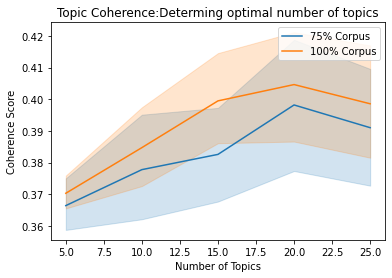

In [189]:


sns.lineplot(x = model_results['Topics'],y=model_results['Coherence'],hue = model_results["Validation_Set"]).set(xlabel = 'Number of Topics', ylabel='Coherence Score',
                                                                                                             title = "Topic Coherence:Determing optimal number of topics")


In [36]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.61)

In [37]:
lda_model.save("lda_model.model")

In [188]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

C:\Users\Harmony Chen\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.360338  0.012961       1        1  53.328087
19    -0.243049  0.037805       2        1  19.464077
1     -0.195399 -0.106061       3        1  13.209837
14    -0.080496  0.073184       4        1   3.722107
7      0.051571  0.005428       5        1   1.056766
13     0.061199  0.003346       6        1   1.019796
18     0.056353 -0.001178       7        1   0.672095
9      0.054428 -0.001706       8        1   0.611299
0      0.056605 -0.002053       9        1   0.604801
11     0.054287 -0.001759      10        1   0.602467
6      0.054915 -0.002521      11        1   0.595659
5      0.054850 -0.001997      12        1   0.591945
8      0.054411 -0.001713      13        1   0.577277
3      0.054008 -0.002034      14        1   0.574206
10     0.054253 -0.001903      15        1   0.571952
17     0.054869 -0.001988      16        1   0.568979
16     0.054517 -0.001882      17        1   0.561877
4      0.054462 -0.002007      18        1   0.558613
12     0.054362 -0.001927      19        1   0.557335
2      0.054192 -0.001995      20        1   0.550824, topic_info=         Term         Freq        Total Category  logprob  loglift
479     pizza   653.000000   653.000000  Default  30.0000  30.0000
307      wait  1869.000000  1869.000000  Default  29.0000  29.0000
34        get  3763.000000  3763.000000  Default  28.0000  28.0000
702     raman   180.000000   180.000000  Default  27.0000  27.0000
233    cheese   654.000000   654.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
5546    urban     0.132960     7.560024  Topic20  -9.6704   1.1609
2962  tuesday     0.134958    49.531201  Topic20  -9.6555  -0.7039
1311   double     0.132776    40.820982  Topic20  -9.6718  -0.5268
1707    mince     0.129420    13.412919  Topic20  -9.6974   0.5606
51      place     0.132741  4558.444094  Topic20  -9.6720  -5.2426

[963 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
16414      1  0.248413           abe
15670      1  0.244069         abide
14873      1  0.246834  accompagnato
13294      1  0.248080     accordian
4779       1  0.479979          acid
...      ...       ...           ...
14314      1  0.183230      yummmmmm
14314      3  0.183230      yummmmmm
14314      4  0.183230      yummmmmm
16248      1  0.244074            ¼a
16248      2  0.244074            ¼a

[2375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 20, 2, 15, 8, 14, 19, 10, 1, 12, 7, 6, 9, 4, 11, 18, 17, 5, 13, 3])

In [38]:
traintopicvector = np.zeros((len(train_dataframe),20))
trainrow=0
for index, row in train_dataframe.iterrows():
    review_text = prepare_text_for_lda(row["Text"])
    review_doc_bow = id2word.doc2bow(review_text)
    predicted_topics = lda_model.get_document_topics(review_doc_bow)
    for k,v in predicted_topics:
        traintopicvector[trainrow,k]=v
    trainrow+=1
traintopicfeature = pd.DataFrame(traintopicvector)

In [233]:
traintopicfeature

C:\Users\Harmony Chen\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.102167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110515,0.000000,0.000000,0.000000,0.000000,0.000000,0.711352,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.120385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.660521,0.000000,0.000000,0.000000,0.159236
2,0.043301,0.043680,0.043309,0.043305,0.043307,0.043305,0.043345,0.043400,0.043307,0.043310,0.043306,0.043304,0.043308,0.043313,0.049301,0.164739,0.043306,0.043306,0.043300,0.049249
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076763,0.290324,0.000000,0.000000,0.000000,0.521313
4,0.000000,0.542915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.313249,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8267,0.000000,0.061177,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.493228,0.329618,0.000000,0.000000,0.000000,0.000000
8268,0.018779,0.109607,0.018878,0.018834,0.018867,0.018804,0.018846,0.019462,0.018833,0.018931,0.018839,0.018871,0.018866,0.018273,0.017454,0.551058,0.018852,0.018846,0.018697,0.020403
8269,0.014195,0.014909,0.014200,0.014199,0.014201,0.014197,0.014197,0.014195,0.014200,0.014206,0.014201,0.014197,0.014200,0.014171,0.014647,0.726543,0.014199,0.014211,0.014191,0.016739
8270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.521295,0.000000,0.000000,0.000000,0.377940


In [39]:
validtopicvector = np.zeros((len(valid_dataframe),20))
validrow=0
for index, row in valid_dataframe.iterrows():
    review_text = prepare_text_for_lda(row["Text"])
    review_doc_bow = id2word.doc2bow(review_text)
    predicted_topics = lda_model.get_document_topics(review_doc_bow)
    for k,v in predicted_topics:
        validtopicvector[validrow,k]=v
    validrow+=1
Validtopicfeature = pd.DataFrame(validtopicvector)

# Word2Vect

In [10]:
import gensim
from gensim import utils
import gensim.downloader
import numpy as np
import sys
from sklearn.datasets import fetch_20newsgroups
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

C:\Users\Harmony Chen\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [43]:
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [157]:
model = gensim.downloader.load('glove-twitter-200')

In [162]:
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
 #   doc = [word for word in doc if word not in en_stop]
    doc = [word for word in doc if word.isalpha()] #restricts string to alphabetic characters only
    
    return doc

#Filter corpus, texts given the function condition_on_doc which takes a doc.
def filter_test_docs(corpus, texts, condition_on_doc):
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]
        #texts = [text for (text, doc) in zip(texts, corpus)]

    #labels = [i for (i, doc) in zip(labels, corpus) if condition_on_doc(doc)]
    missing_index = [corpus.index(doc) for doc in corpus if not condition_on_doc(doc) ]
    corpus = [doc for doc in corpus if condition_on_doc(doc)]
 #   corpus = [doc for doc in corpus if not condition_on_doc(doc)]
    
    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts, missing_index)

def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.index_to_key]
    return np.mean(word2vec_model[doc], axis=0)

def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.index_to_key for word in doc)

In [ ]:
dataset["tokenized"]

In [174]:
traincorpus=dataset["tokenized"].tolist()


In [175]:
#train dataset preparation
train_corpus = []
for index,row in dataset.iterrows():
    train_corpus.append(row["Text"])

In [176]:
traincorpus, train_corpus,missing_index1 = filter_test_docs(traincorpus, train_corpus, lambda doc: (len(doc) != 0))
traincorpus, train_corpus,missing_index2 = filter_test_docs(traincorpus, train_corpus, lambda doc: has_vector_representation(model, doc))


26 docs removed
7 docs removed


In [179]:
set(missing_index1)

{6208}

In [180]:
set(missing_index2)

{5605, 43717, 52034, 60080, 68782, 81958}

In [190]:
len(traincorpus)

90873

In [191]:
trainx =[]
for doc in traincorpus: #look up each doc in model
    trainx.append(document_vector(model, doc))

In [193]:
trainx[1].shape

(200,)

In [194]:
for index in reversed(missing_index2):
    trainx.insert(index,np.zeros((200,)).astype('float32'))
for index in reversed(missing_index1):
    trainx.insert(index,np.zeros((200,)).astype('float32'))

In [195]:
len(trainx)

90906

In [204]:
wordembedding_list = [embed.tolist() for embed in trainx]

In [231]:
X_wordembedding = pd.DataFrame({"Word_Embedding_Vector":pd.Series(wordembedding_list)}) #list to pandas
X_wordembedding.shape

(90906, 1)

In [232]:
X_wordembedding.head()

,Word_Embedding_Vector
0,"[-0.15083123743534088, 0.011999939568340778, 0..."
1,"[-0.22720351815223694, -0.15442503988742828, 0..."
2,"[-0.4370470643043518, -0.05270380154252052, 0...."
3,"[-0.3542546331882477, -0.03530864045023918, -0..."
4,"[-0.3014901280403137, -0.05742964521050453, -0..."


In [792]:
X_wordembedding

,Word_Embedding_Vector
0,"[-0.15083123743534088, 0.011999939568340778, 0..."
1,"[-0.22720351815223694, -0.15442503988742828, 0..."
2,"[-0.4370470643043518, -0.05270380154252052, 0...."
3,"[-0.3542546331882477, -0.03530864045023918, -0..."
4,"[-0.3014901280403137, -0.05742964521050453, -0..."
...,...
90901,"[-0.26058366894721985, -0.05718192830681801, 0..."
90902,"[-0.2896883189678192, -0.004868207033723593, 0..."
90903,"[-0.08450919389724731, -0.0708717331290245, -0..."
90904,"[-0.30610382556915283, -0.06229681149125099, 0..."


In [94]:
dataset_word_embedding["Word_Embedding_Vector"] = dataset_word_embedding["Word_Embedding_Vector"].apply(lambda x: 
                           np.fromstring(x.replace('[','')
                                .replace(']','').replace(',',' '), sep=' '))


In [96]:
dataset_word_embedding["Word_Embedding_Vector"][0]

array([-1.50831237e-01,  1.19999396e-02,  1.91452190e-01,  1.02365464e-01,
        1.99825287e-01,  1.53795823e-01,  3.35302114e-01,  1.22496188e-01,
        1.13664351e-01, -2.52542317e-01, -1.61405146e-01, -8.31401348e-02,
       -6.36944175e-01,  7.82181025e-02,  4.51555429e-03,  1.12217784e-01,
        1.67640019e-02, -9.63678807e-02, -1.70440376e-01,  5.50897829e-02,
        8.69138837e-02,  1.73381791e-02, -1.91165105e-01,  1.63298532e-01,
        3.49388681e-02,  8.21373403e-01, -6.28563389e-02, -3.44889238e-02,
        2.49641035e-02,  5.97838722e-02,  1.55812399e-02, -7.53535628e-02,
       -6.02812357e-02, -2.22967431e-01, -8.72971714e-02, -1.63134366e-01,
        1.47938818e-01,  3.19700062e-01,  2.39805669e-01,  1.07741661e-01,
        6.46143556e-02, -1.24283932e-01, -1.45794451e-01, -1.25292167e-01,
        2.24074423e-01, -7.50548244e-02,  4.26745340e-02,  1.21519648e-01,
        1.07570179e-01, -1.70571581e-01, -1.50812194e-02, -8.03049207e-02,
        2.63224076e-02,  

In [92]:
dataset_word_embedding["Word_Embedding_Vector"]

0        [-0.15083123743534088, 0.011999939568340778, 0...
1        [-0.22720351815223694, -0.15442503988742828, 0...
2        [-0.4370470643043518, -0.05270380154252052, 0....
3        [-0.3542546331882477, -0.03530864045023918, -0...
4        [-0.3014901280403137, -0.05742964521050453, -0...
                               ...                        
90901    [-0.26058366894721985, -0.05718192830681801, 0...
90902    [-0.2896883189678192, -0.004868207033723593, 0...
90903    [-0.08450919389724731, -0.0708717331290245, -0...
90904    [-0.30610382556915283, -0.06229681149125099, 0...
90905    [-0.14019443094730377, -0.048116397112607956, ...
Name: Word_Embedding_Vector, Length: 90906, dtype: object

In [784]:
dataset_word_embedding = pd.concat([Reveiw_centric_Text_feature,X_wordembedding],axis=1)
dataset_word_embedding.head()

,Reviewer_id,Product_id,Text,Rating,Label,Word_Embedding_Vector
0,923,0,The food at snack is a selection of popular Gr...,3,1,"[-0.15083123743534088, 0.011999939568340778, 0..."
1,927,0,Snack is great place for a Â casual sit down l...,4,1,"[-0.22720351815223694, -0.15442503988742828, 0..."
2,930,0,Love this place! Â Try the Chicken sandwich or...,4,1,"[-0.4370470643043518, -0.05270380154252052, 0...."
3,931,0,My friend and I were intrigued by the nightly ...,4,1,"[-0.3542546331882477, -0.03530864045023918, -0..."
4,940,0,"For lunch, my friend and I had: -Lamb sandwich...",4,0,"[-0.3014901280403137, -0.05742964521050453, -0..."


In [237]:
dataset_word_embedding.drop(["Date_x","Count (P)_x","Date_y","Count (P)_y"],axis=1,inplace=True)
dataset_word_embedding.head()

,Reviewer_id,Product_id,Text,Rating,Label,Word_Embedding_Vector
0,923,0,The food at snack is a selection of popular Gr...,3,0,"[-0.15083123743534088, 0.011999939568340778, 0..."
1,927,0,Snack is great place for a Â casual sit down l...,4,0,"[-0.22720351815223694, -0.15442503988742828, 0..."
2,930,0,Love this place! Â Try the Chicken sandwich or...,4,0,"[-0.4370470643043518, -0.05270380154252052, 0...."
3,931,0,My friend and I were intrigued by the nightly ...,4,0,"[-0.3542546331882477, -0.03530864045023918, -0..."
4,940,0,"For lunch, my friend and I had: -Lamb sandwich...",4,1,"[-0.3014901280403137, -0.05742964521050453, -0..."


In [238]:
dataset_word_embedding.to_csv("dataset_word_embedding.csv",index=False)

In [77]:
dataset_word_embedding = pd.read_csv("dataset_word_embedding.csv")
dataset_word_embedding.head()

,Reviewer_id,Product_id,Text,Rating,Label,Word_Embedding_Vector
0,923,0,The food at snack is a selection of popular Gr...,3,0,"[-0.15083123743534088, 0.011999939568340778, 0..."
1,927,0,Snack is great place for a Â casual sit down l...,4,0,"[-0.22720351815223694, -0.15442503988742828, 0..."
2,930,0,Love this place! Â Try the Chicken sandwich or...,4,0,"[-0.4370470643043518, -0.05270380154252052, 0...."
3,931,0,My friend and I were intrigued by the nightly ...,4,0,"[-0.3542546331882477, -0.03530864045023918, -0..."
4,940,0,"For lunch, my friend and I had: -Lamb sandwich...",4,1,"[-0.3014901280403137, -0.05742964521050453, -0..."


In [98]:
np.zeros((200,)).astype(np.float16).mean()

0.0

In [160]:
rowindex = []
for index,row in dataset_word_embedding.iterrows():
    if (row["Word_Embedding_Vector"].mean()==0):
        rowindex.append(index)
print (rowindex)

[5605, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 43744, 43745, 52063, 60110, 68813, 81990]


In [808]:
cosine_distance_wordembedding_method

<function __main__.cosine_distance_wordembedding_method(df)>

In [241]:
from scipy.spatial.distance import cosine
def cosine_distance_wordembedding_method(vector_1, vector_2):
    return cosine(vector_1, vector_2)

In [156]:
dataset_word_embedding["Word_Embedding_Vector"]=dataset_word_embedding["Word_Embedding_Vector"].apply(np.float16)

In [167]:
from scipy.spatial.distance import pdist, squareform
# only pairwise distance with itself
# vectorized, no doubling data
def cosine_distance_wordembedding_method(df):
    out = pdist(np.stack(df), metric = "cosine")
    cosine_similarity = squareform(out)
    return np.mean(cosine_similarity)

In [12]:
from scipy.spatial.distance import pdist, squareform
# only pairwise distance with itself
# vectorized, no doubling data
def cosine_distance_wordembedding_method_max(df):
    out = pdist(np.stack(df), metric = "cosine")
    cosine_similarity = squareform(out)
    return np.max(cosine_similarity)

In [119]:
# only pairwise distance with itself
# vectorized, no doubling data
def cosine_distance_wordembedding_method_min(df):
    out = pdist(np.stack(df), metric = "cosine")
    cosine_similarity = squareform(out)
    return np.min(cosine_similarity)

In [168]:
Reviewer_content_similarity_word_vector =  dataset_word_embedding.drop(rowindex).groupby("Reviewer_id")["Word_Embedding_Vector"].apply(cosine_distance_wordembedding_method)
Product_content_similarity_word_vector =  dataset_word_embedding.drop(rowindex).groupby("Product_id")["Word_Embedding_Vector"].apply(cosine_distance_wordembedding_method)

In [162]:
Reviewer_most_content_similarity_word_vector = dataset_word_embedding.drop(rowindex).groupby("Reviewer_id")["Word_Embedding_Vector"].apply(cosine_distance_wordembedding_method_max)
Product_most_content_similarity_word_vector =  dataset_word_embedding.drop(rowindex).groupby("Product_id")["Word_Embedding_Vector"].apply(cosine_distance_wordembedding_method_max)

In [120]:
Reviewer_least_content_similarity_word_vector = dataset_word_embedding.groupby("Reviewer_id")["Word_Embedding_Vector"].apply(cosine_distance_wordembedding_method_min)
Product_least_content_similarity_word_vector = dataset_word_embedding.groupby("Product_id")["Word_Embedding_Vector"].apply(cosine_distance_wordembedding_method_min)

In [816]:
Product_content_similarity_word_vector

Product_id
0      0.102539
1      0.119379
2      0.077351
3      0.063187
4      0.090170
         ...   
918    0.066818
919    0.103355
920    0.081404
921    0.095212
922    0.100877
Name: Word_Embedding_Vector, Length: 873, dtype: float64

In [169]:
Product_content_simi = pd.DataFrame(Product_content_similarity_word_vector)
Reviewer_content_simi= pd.DataFrame(Reviewer_content_similarity_word_vector)
Product_most_content_simi= pd.DataFrame(Product_most_content_similarity_word_vector)
Reviewer_most_content_simi = pd.DataFrame(Reviewer_most_content_similarity_word_vector)

In [170]:
Product_content_simi.rename(columns = {"Word_Embedding_Vector":"Product_content_consine_similarity"},inplace=True)
Reviewer_content_simi.rename(columns = {"Word_Embedding_Vector":"Reviewer_content_consine_similarity"},inplace=True)
Product_most_content_simi.rename(columns = {"Word_Embedding_Vector":"Product_most_content_consine_similarity"},inplace=True)
Reviewer_most_content_simi.rename(columns = {"Word_Embedding_Vector":"Reviewer_most_content_consine_similarity"},inplace=True)


In [164]:
Reviewer_content_simi[Reviewer_content_simi["Word_Embedding_Vector"].isna()]

,Word_Embedding_Vector
Reviewer_id,


In [122]:
Reviewer_content_simi.rename(columns = {"Word_Embedding_Vector":"Reviewer_least_content_consine_similarity"},inplace=True)

In [123]:
Reviewer_content_simi

,Reviewer_least_content_consine_similarity
Reviewer_id,
923,0.0
927,0.0
930,0.0
931,0.0
940,0.0
...,...
146523,0.0
146783,0.0
146796,0.0


In [124]:
Product_content_simi.rename(columns = {"Word_Embedding_Vector":"Product_least_content_consine_similarity"},inplace=True)

In [827]:
Product_content_simi.shape

(873, 1)

In [175]:
Product_Reviewer_Features_Label = pd.read_excel("Product_Reviewer_Features_Label_contentsimilarity.xlsx")

In [177]:
Product_Reviewer_Features_Label = Product_Reviewer_Features_Label.merge(Reviewer_content_simi,how="left",on="Reviewer_id")
Product_Reviewer_Features_Label = Product_Reviewer_Features_Label.merge(Product_content_simi,how="left",on="Product_id")
Product_Reviewer_Features_Label = Product_Reviewer_Features_Label.merge(Product_most_content_simi,how="left",on="Product_id")
Product_Reviewer_Features_Label = Product_Reviewer_Features_Label.merge(Reviewer_most_content_simi,how="left",on="Reviewer_id")


In [176]:
Product_Reviewer_Features_Label.drop(["Reviewer_content_consine_similarity","Product_content_consine_similarity"],axis=1,inplace=True)

In [171]:
Product_Reviewer_Features_Label.drop(["Reviewer_content_consine_similarity","Product_content_consine_similarity","Product_most_content_consine_similarity","Reviewer_most_content_consine_similarity"],axis=1,inplace=True)

In [178]:
Product_Reviewer_Features_Label.isnull().sum()

Reviewer_id                                          0
Product_id                                           0
Reviewer_ReviewContent_Sent_len                      0
Reviewer_ReviewContent_SUB_Len                       0
Reviewer_ReviewContent_OBJ_Len                       0
Reviewer_ReviewContent_First_Third_PRP               0
Reviewer_ReviewContent_First_Third_PRP_ratio         0
Reviewer_ReviewContent_Second_PRP                    0
Reviewer_ReviewContent_Second_PRP_ratio              0
Reviewer_ReviewContent_avg_sent_len                  0
Reviewer_ReviewContent_avg_first_third_ratio         0
Reviewer_ReviewContent_avg_second_ratio              0
Reviewer_ReviewContent_avg_sub_ratio                 0
Reviewer_ReviewContent_avg_obj_ratio                 0
Reviewer_ReviewContent_avg_sub_to_allpro_ratio       0
Reviewer_ReviewContent_avg_obj_to_allpro_ratio       0
Reviewer_Average_Rank                                0
Reviewer_Rank_SD                                     0
Reviewer_B

In [179]:
Product_Reviewer_Features_Label.to_excel("Product_Reviewer_Features_Label_contentsimilarity_new.xlsx")

In [132]:
Product_Reviewer_Features_Label.drop(["Reviewer_least_content_consine_similarity","Product_least_content_consine_similarity"],axis=1,inplace=True)

In [129]:
Product_Reviewer_Features_Label[["Reviewer_id","Label","Reviewer_content_consine_similarity","Reviewer_most_content_consine_similarity","Reviewer_least_content_consine_similarity"]]

,Reviewer_id,Label,Reviewer_content_consine_similarity,Reviewer_most_content_consine_similarity,Reviewer_least_content_consine_similarity
0,923,1,0.089281,0.265426,0.0
1,923,1,0.089281,0.265426,0.0
2,923,1,0.089281,0.265426,0.0
3,923,1,0.089281,0.265426,0.0
4,923,1,0.089281,0.265426,0.0
...,...,...,...,...,...
90901,146907,0,0.095073,0.177968,0.0
90902,146907,0,0.095073,0.177968,0.0
90903,149108,0,0.074956,0.142913,0.0
90904,149108,0,0.074956,0.142913,0.0


In [113]:
Product_content_simi[Product_content_simi["Word_Embedding_Vector"].isnull()]

KeyError: 'Word_Embedding_Vector'

In [722]:
dataset_word_embedding["Word_Embedding_Vector"]

0

In [757]:
Reviewer_content_similarity_word_vector.isnull().sum()

33

In [182]:
reviewer_similarity = Product_Reviewer_Features_Label.groupby(["Label","Reviewer_id"])["Reviewer_most_content_consine_similarity"].agg(['mean'])

In [180]:
product_similarity = Product_Reviewer_Features_Label.groupby(["Label","Product_id"])["Product_most_content_consine_similarity"].agg(['mean'])

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

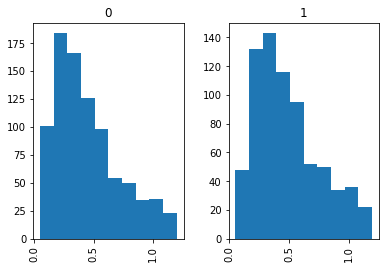

In [181]:
product_similarity.hist(by="Label")

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

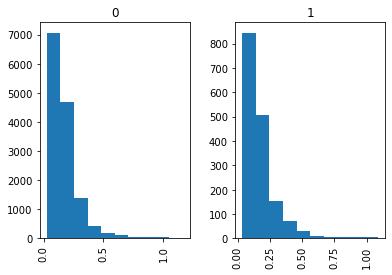

In [183]:
reviewer_similarity.hist(by="Label")

In [46]:
#train dataset preparation
train_corpus = []
for index,row in train_dataframe.iterrows():
    train_corpus.append(row["Text"])
#TrainY = train_Y.tolist()
traincorpus = [preprocess(text) for text in train_corpus]
traincorpus, train_corpus,missing_index1 = filter_test_docs(traincorpus, train_corpus, lambda doc: (len(doc) != 0))
traincorpus, train_corpus,missing_index2 = filter_test_docs(traincorpus, train_corpus, lambda doc: has_vector_representation(model, doc))

trainx =[]
for doc in traincorpus: #look up each doc in model
    trainx.append(document_vector(model, doc))
    
train_X_wordfeature = np.array(trainx) #list to array
train_X_wordfeature.shape

train_X_wordfeature[1]

0 docs removed
0 docs removed


array([-5.90702221e-02,  1.20855376e-01, -8.22401717e-02, -8.81951526e-02,
       -3.57059799e-02,  3.62629108e-02, -2.97691114e-02,  7.18608201e-02,
        4.55867909e-02, -1.58788586e+00,  1.67962223e-01, -8.80596265e-02,
       -7.95242339e-02,  2.06512928e-01, -3.30446661e-02,  9.60668027e-02,
       -8.35262015e-02, -1.58707146e-02, -1.64288599e-02, -8.23438168e-03,
        4.53482009e-02,  3.10096383e-01,  1.71733096e-01,  4.27705161e-02,
       -2.16241494e-01, -4.55259979e-02,  1.53873507e-02, -1.89402595e-01,
       -3.15978602e-02,  1.59100331e-02,  6.79605082e-03,  2.46605575e-01,
       -2.37089321e-01, -4.94822394e-04, -9.80428278e-01,  1.31311104e-01,
       -4.85807881e-02,  9.68958437e-02,  2.71684211e-02,  1.36904540e-02,
        6.37773750e-03, -2.27274746e-01, -4.15931791e-02,  1.98425744e-02,
        1.00991167e-01,  1.62561014e-01,  1.96166024e-01,  1.64258271e-01,
       -5.01016490e-02,  9.14116427e-02,  5.96663170e-02, -1.44651413e-01,
        3.74630876e-02, -

In [47]:
train_X_wordfeature.shape

(8272, 300)

In [48]:
#valid dataset preparation
valid_edit_corpus = []
for index,row in valid_dataframe.iterrows():

    valid_edit_corpus.append(row["Text"])
#ValidY=valid_dataframe['label'].tolist()
validcorpus = [preprocess(text) for text in valid_edit_corpus]
validcorpus, valid_edit_corpus, missing_index1 = filter_test_docs(validcorpus, valid_edit_corpus, lambda doc: (len(doc) != 0))
validcorpus, valid_edit_corpus, missing_index2 = filter_test_docs(validcorpus, valid_edit_corpus, lambda doc: has_vector_representation(model, doc))
valid_x =[]
for doc in validcorpus: #look up each doc in model
    valid_x.append(document_vector(model, doc))
    
Valid_X_wordfeature = np.array(valid_x) #list to array
Valid_X_wordfeature.shape

1 docs removed
3 docs removed


(2754, 300)

In [50]:
missing_index1

[684]

In [49]:
missing_index2

[680, 1742, 680]

In [51]:
valid_x.insert(missing_index2[2],np.zeros((300,)).astype('float32'))
valid_x.insert(missing_index2[1],np.zeros((300,)).astype('float32'))
valid_x.insert(missing_index2[0],np.zeros((300,)).astype('float32'))
valid_x.insert(missing_index1[0],np.zeros((300,)).astype('float32'))


In [52]:
Valid_X_wordfeature = np.array(valid_x) 

In [53]:
train_X_wordfeature = pd.DataFrame(train_X_wordfeature)
Valid_X_wordfeature = pd.DataFrame(Valid_X_wordfeature)

In [294]:
for index,row in valid_dataframe.iterrows():
    if len(preprocess(row["Text"]))<2:
        print( row["Text"],row["Label"])

C:\Users\Harmony Chen\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


magnificent!!! 0
Delicious!!! 1
yumm 0
A-Ok 0
soulful 0
Excellent! 0
nom 0
Delisshhhhhh! 0
YUMM 0
Good. 0
Excellent! 0
Yummy 0


In [257]:
len(train_Y)

C:\Users\Harmony Chen\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


8272

In [159]:
train_ratio = 0.8 # 80% for training, 20% for validation
random_seed = 500

train_data = sampledataframe.sample(frac=train_ratio, random_state=random_seed)
valid_data = sampledataframe.drop(train_data.index)


In [160]:
train_X = train_data[feature_columns[:-2]]
train_Y = train_data['Label']
valid_X = valid_data[feature_columns[:-2]]
valid_Y = valid_data['Label']

In [177]:
valid_Y_hat = adb_model.predict(valid_X)
accuracy = accuracy_score(valid_Y, valid_Y_hat)
accuracy

0.7633472169632715

In [375]:
train_X = pd.concat([traintopicfeature,train_X_wordfeature],axis=1)
train_Y = train_dataframe["Label"]
valid_X = pd.concat([Validtopicfeature,Valid_X_wordfeature],axis=1)
valid_Y = valid_dataframe["Label"]

C:\Users\Harmony Chen\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [368]:
Validtopicfeature.shape

C:\Users\Harmony Chen\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2758, 20)

In [388]:
valid_X.tail()

C:\Users\Harmony Chen\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
2753,0.030528,0.033098,0.030532,0.030532,0.030531,0.03053,0.03053,0.030537,0.030531,0.03053,...,-0.094567,-0.261025,0.032923,0.037032,-0.020807,-0.006334,-0.097025,0.006673,0.017068,-0.107368
2754,0.000000,0.064281,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,...,-0.131909,0.026793,0.080834,0.045878,0.050292,-0.117947,0.139120,0.161393,-0.002296,0.022572
2755,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.162693,0.000000,0.00000,...,-0.100793,-0.029638,0.125978,0.026953,0.066923,-0.093242,0.071059,0.101375,-0.000959,-0.023929
2756,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,...,-0.151384,-0.042414,0.127405,0.023186,0.017712,-0.072819,0.081367,0.109436,-0.169670,-0.074346
2757,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,...,-0.165665,-0.077816,0.090741,0.047345,-0.033364,-0.118698,0.029050,0.160180,-0.048188,-0.019399


In [395]:
valid_dataframe.to_csv("valid_dataset.csv",index=False)

C:\Users\Harmony Chen\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [396]:
train_dataframe.to_csv("train_dataset.csv",index=False)

C:\Users\Harmony Chen\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
train_dataframe = pd.read_csv("train_dataset.csv")
valid_dataframe = pd.read_csv("valid_dataset.csv")

In [706]:
train_dataframe.head()

,Reviewer_id,Product_id,Reviewer_ReviewContent_Sent_len,Reviewer_ReviewContent_SUB_Len,Reviewer_ReviewContent_OBJ_Len,Reviewer_ReviewContent_First_Third_PRP,Reviewer_ReviewContent_First_Third_PRP_ratio,Reviewer_ReviewContent_Second_PRP,Reviewer_ReviewContent_Second_PRP_ratio,Reviewer_ReviewContent_avg_sent_len,...,Product_Behavior_group_extreme_rating_ratio,Product_Behavior_group_toprating_rating_ratio,Product_Behavior_group_buttomrating_rating_ratio,Product_Behavior_group_posrating_rating_ratio,Product_Behavior_group_negrating_rating_ratio,Product_Behavior_Early_Review_Ratio,Text,Rating,Label,Reviewer_content_consine_similarity
38508,13025,337,93,3,0,0,0.000000,0,0.000000,163.666667,...,0.095833,0.095833,0.008333,0.095833,0.037500,0.017241,This place is highly recommended! The food is ...,4,0,0.029831
70057,39806,133,320,8,6,3,0.009375,0,0.000000,425.333333,...,0.093628,0.093628,0.009103,0.093628,0.031209,0.005263,So I went to this place for breakfast and must...,4,0,0.034621
79011,56726,508,142,5,3,3,0.021127,0,0.000000,159.428571,...,0.082126,0.082126,0.003623,0.082126,0.032609,0.029557,Went here for a nice lunch and that's what I g...,5,0,0.086207
88360,95235,718,152,2,5,1,0.006579,1,0.006579,187.666667,...,0.109948,0.109948,0.005236,0.109948,0.015707,0.021739,it has its own unique style but I wasnt thrill...,2,1,0.061186
41228,14388,276,145,3,2,0,0.000000,2,0.013793,186.000000,...,0.074144,0.074144,0.005703,0.074144,0.053232,0.007463,"Good food, but the wait. The wait! Maybe I'm t...",3,1,0.059715


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
#vectorizer = CountVectorizer(stop_words = "english",ngram_range=(1,2),min_df=0., max_df=1.)
vectorizer = TfidfVectorizer()
vectorizer.fit(train_dataframe['Text'])
trainidf = vectorizer.transform(train_dataframe['Text'])
valididf = vectorizer.transform(valid_dataframe['Text'])

In [4]:
print (trainidf.shape)
print (valididf.shape)

(8272, 21692)
(2758, 21692)


In [7]:
# Dimensionality reduction
svd = TruncatedSVD(n_components=3500, random_state=42)
trainX_svd = svd.fit_transform(trainidf)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.92


In [8]:
validX_svd = svd.transform(valididf)

trainX_svd = pd.DataFrame(trainX_svd)
validX_svd = pd.DataFrame(validX_svd)

In [21]:
train_X = trainX_svd
train_Y = train_dataframe["Label"]
valid_X = validX_svd
valid_Y = valid_dataframe["Label"]

In [57]:
train_X = pd.concat([trainX_svd,traintopicfeature],axis=1)
train_Y = train_dataframe["Label"]
valid_X = pd.concat([validX_svd,Validtopicfeature],axis=1)
valid_Y = valid_dataframe["Label"]

# LDA

In [13]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [14]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [121]:
df = sampledataframe
df["Text"]=df["Text"].astype(str)

In [122]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['Text'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

Time to clean and tokenize 13787 articles: 0.3393145680427551 min


In [123]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('gitano', 1),
 ('almondsugar', 1),
 ('bonarda', 1),
 ('toscano', 1),
 ('bisforbruschetta', 1),
 ('flowerth', 1),
 ('scorza', 1),
 ('cacciocavalo', 1),
 ('faculti', 1),
 ('youtubecomwatchvbx', 1)]

In [124]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 13787 
average document length 52.03952999202147 
minimum document length 0 
maximum document length 477


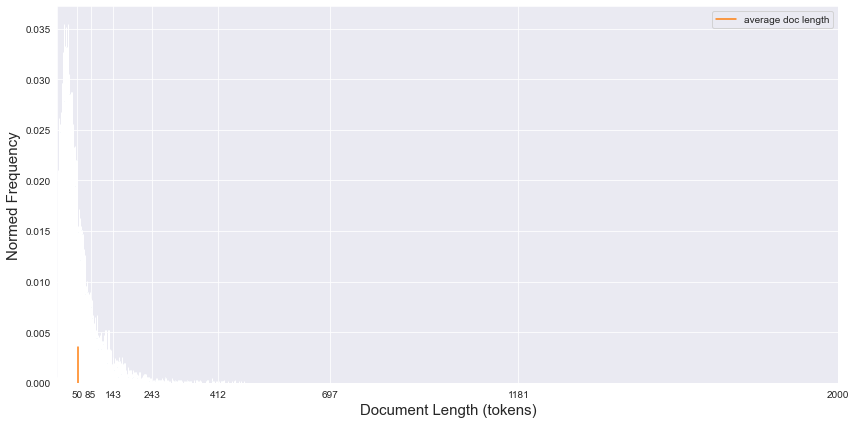

In [125]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, density=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [126]:
# only keep articles with more than 10 tokens, otherwise too short

df = df[df['tokenized'].map(len) >= 10]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 12451 articles


In [131]:
msk = np.random.rand(len(df)) < 0.999
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [128]:
train_df.head()

,Text,Label,tokenized
0,There is nothing weirder than walking into a p...,1,"[noth, weirder, walk, place, thought, hadnt, e..."
1,Eh. I probably came at the wrong time --- Sund...,1,"[eh, probabl, came, wrong, time, sunday, brunc..."
2,LOVE. This is a terrific hole-in-the-wall spot...,1,"[love, terrif, holeinthewal, spot, food, menu,..."
3,"Having eaten here my fair share, I think it's ...",1,"[eaten, fair, share, think, time, give, credit..."
4,When I inspected the kitchen a year ago it was...,1,"[inspect, kitchen, year, ago, clean, surpris, ..."


In [129]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 20
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [132]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  12451 articles:  0.2367464264233907 min


In [844]:
lda.save("lda2.model")

In [133]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(15,
  '0.071*"sandwich" + 0.043*"pork" + 0.022*"meat" + 0.018*"tri" + 0.017*"pull" + 0.016*"good" + 0.015*"best" + 0.015*"bbq" + 0.015*"duck" + 0.014*"corn" + 0.013*"hummu" + 0.012*"falafel" + 0.010*"bread" + 0.010*"one" + 0.010*"sprout" + 0.009*"roast" + 0.009*"empanada" + 0.009*"delici" + 0.009*"weve" + 0.009*"belli"'),
 (4,
  '0.038*"pasta" + 0.027*"fresh" + 0.026*"italian" + 0.024*"salad" + 0.020*"bread" + 0.017*"dish" + 0.017*"good" + 0.017*"delici" + 0.015*"great" + 0.014*"seafood" + 0.013*"restaur" + 0.011*"also" + 0.011*"oil" + 0.010*"sauc" + 0.010*"attent" + 0.009*"excel" + 0.009*"cook" + 0.009*"well" + 0.009*"oliv" + 0.009*"recommend"'),
 (8,
  '0.086*"pizza" + 0.025*"pie" + 0.019*"wait" + 0.018*"slice" + 0.017*"best" + 0.016*"line" + 0.013*"get" + 0.012*"crust" + 0.011*"go" + 0.011*"good" + 0.010*"place" + 0.010*"sauc" + 0.010*"long" + 0.010*"one" + 0.009*"make" + 0.009*"eat" + 0.008*"like" + 0.008*"fresh" + 0.008*"brooklyn" + 0.008*"worth"'),
 (12,
  '0.017*"delici" + 0.0

In [134]:
lda.show_topic(topicid=4, topn=20)

[('pasta', 0.037501734),
 ('fresh', 0.026967222),
 ('italian', 0.026293013),
 ('salad', 0.024423482),
 ('bread', 0.019730093),
 ('dish', 0.017260063),
 ('good', 0.016986182),
 ('delici', 0.016913505),
 ('great', 0.01500893),
 ('seafood', 0.013700188),
 ('restaur', 0.013489726),
 ('also', 0.0110339075),
 ('oil', 0.010518553),
 ('sauc', 0.009800555),
 ('attent', 0.009610789),
 ('excel', 0.009466818),
 ('cook', 0.009149057),
 ('well', 0.00886029),
 ('oliv', 0.008825478),
 ('recommend', 0.008708765)]

In [135]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,2])
print(random_article_index)

11124


In [136]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

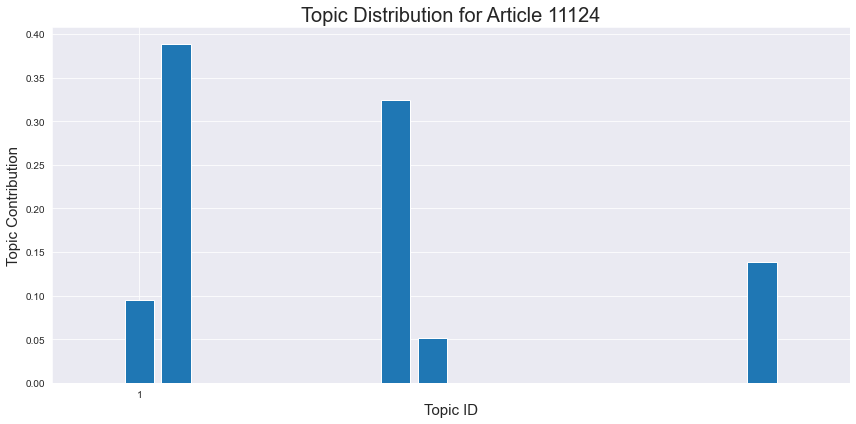

In [137]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(1,20,1))
fig.tight_layout()
plt.show()

In [138]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

2 [('good', 0.052853003), ('food', 0.047615025), ('place', 0.042380556), ('realli', 0.025734553), ('like', 0.025455246), ('get', 0.020651968), ('price', 0.019946082), ('go', 0.019945713), ('dont', 0.018175045), ('pretti', 0.0151749095)] 

8 [('pizza', 0.08614686), ('pie', 0.0246445), ('wait', 0.018747834), ('slice', 0.017975578), ('best', 0.017497081), ('line', 0.016416054), ('get', 0.0133456895), ('crust', 0.012353729), ('go', 0.011338436), ('good', 0.010596503)] 

18 [('brunch', 0.12193028), ('egg', 0.06090817), ('coffe', 0.03172935), ('breakfast', 0.031106377), ('biscuit', 0.018527037), ('sunday', 0.01841565), ('wait', 0.01825897), ('pancak', 0.018100688), ('waffl', 0.016214743), ('toast', 0.01578821)] 

1 [('great', 0.045930073), ('burger', 0.036724158), ('place', 0.033079684), ('time', 0.025452187), ('food', 0.023447353), ('neighborhood', 0.022035496), ('beer', 0.020592736), ('ive', 0.018973464), ('alway', 0.018505218), ('spot', 0.017241182)] 

9 [('dumpl', 0.06606794), ('soup', 0

In [140]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,2])
print(test_df.iloc[random_article_index,2])

3
['love', 'place', 'select', 'beer', 'cider', 'kombucha', 'impress', 'food', 'good', 'offer', 'interest', 'flavor', 'staff', 'great', 'love', 'place', 'want', 'picki', 'complain', 'would', 'get', 'littl', 'loud', 'best', 'acoust', 'venu', 'music', 'sometim', 'play', 'tad', 'loud', 'lot', 'patron', 'tri', 'convers', 'guess', 'problem', 'barspub']


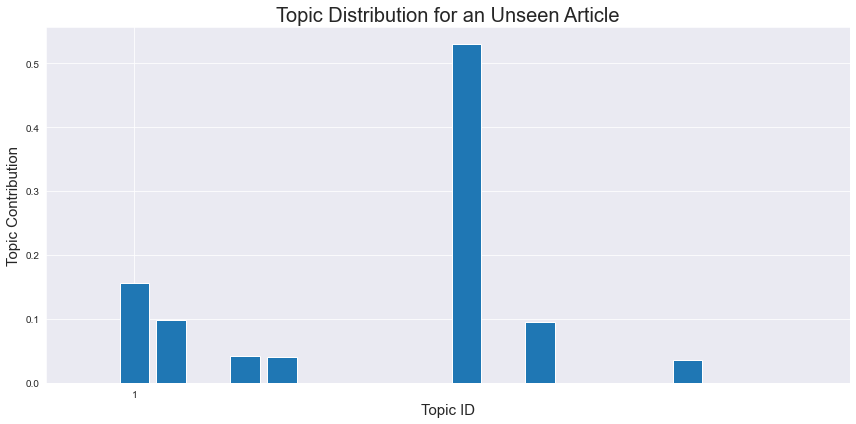

In [141]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(1,20,1))
fig.tight_layout()
plt.show()

In [142]:
doc_topic_dist.shape

(86299, 20)

In [143]:
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

10 [('food', 0.04338321), ('great', 0.039493017), ('place', 0.031392068), ('servic', 0.020656012), ('good', 0.020503948), ('nice', 0.016393978), ('go', 0.01453644), ('back', 0.012708069), ('love', 0.012007116), ('restaur', 0.011955438)] 

1 [('great', 0.045930073), ('burger', 0.036724158), ('place', 0.033079684), ('time', 0.025452187), ('food', 0.023447353), ('neighborhood', 0.022035496), ('beer', 0.020592736), ('ive', 0.018973464), ('alway', 0.018505218), ('spot', 0.017241182)] 

2 [('good', 0.052853003), ('food', 0.047615025), ('place', 0.042380556), ('realli', 0.025734553), ('like', 0.025455246), ('get', 0.020651968), ('price', 0.019946082), ('go', 0.019945713), ('dont', 0.018175045), ('pretti', 0.0151749095)] 

12 [('delici', 0.016658796), ('chees', 0.015639154), ('perfect', 0.014236548), ('salad', 0.010868264), ('greek', 0.009245578), ('ravioli', 0.008863437), ('night', 0.008660835), ('plate', 0.008565148), ('order', 0.008265664), ('sauc', 0.008213311)] 

4 [('pasta', 0.037501734)

In [144]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(12439, 20)

In [148]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T + np.zeros([20, 12439])# take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [149]:
def get_most_similar_documents(query,matrix,k=19):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [150]:
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [151]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
Counter(most_similar_df["Label"])

Counter({1: 10, 0: 9})

# Content Similarity